In [49]:
import numpy as np
import scipy.linalg
import cvxpy as cp
from numpy.linalg import matrix_power
import matplotlib.pyplot as plt
import mosek

A Robust Learning Approach for Regression Models Based on Distributionally Robust Optimization

In [50]:
def dlqr(A,B,Q,R):
    """
    Calculates the optimal gain matrix K for system
    x[k+1] = A x[k] + B u[k]
    with cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k], such that
    u[k] = -K x[k]
    
    Returns: 
        -K
    """
    # first, solve the ricatti equation
    P = np.matrix(scipy.linalg.solve_discrete_are(A, B, Q, R))
    # compute the LQR gain
    K = np.matrix(scipy.linalg.inv(B.T*P*B+R)*(B.T*P*A))
    return -K

In [51]:
def disc_linear_system(A,B,delta_t):
    '''
    Discrete a linear system with implicit Euler
    x[k+1] = (I - delta_t * A)^{-1} @ x[k] + (I - delta_t * A)^{-1} @ (delta_t * B) @ u[k]
    
    Returns:
        Ak
        Bk
    
    ''' 
    Nx = np.shape(A)[0]
    Ix = np.identity(Nx)
    
    Ak = np.linalg.inv(Ix - delta_t * A)
    Bk = np.linalg.inv(Ix - delta_t * A) @ (delta_t * B)
    
    
    return Ak, Bk

In [52]:
def simulation_Euler(Ak, Bk, x, u ):
    '''
    Simulate with implicit Euler
    x[k+1] = (I - delta_t * A)^{-1} @ x[k] + (I - delta_t * A)^{-1} @ (delta_t * B) @ u[k]    
    ''' 
    x_next = Ak @ x + Bk @ u

    
    return x_next

In [53]:
def RK4_np(f, x, u, t, h):
    """
    Runge-Kutta 4th order solver using numpy array data type.

    Args:
        f: A function returning first order ODE in 2D numpy array (Nx x 1).
        x: Current value (list or numpy array). 
        t: Current time.
        h: Step length.
    Returns:
        x_next: Vector of next value in 2D numpy array (Nx x 1)
    """
    x = np.reshape(x, (np.shape(x)[0], -1))    # Reshape x to col vector in np 2D array
    k1 = f(t, x, u)
    k2 = f(t + h / 2, x + h / 2 * k1, u)
    k3 = f(t + h / 2, x + h / 2 * k2, u)
    k4 = f(t + h, x + h * k3, u)
    x_next = x + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return x_next

In [54]:
# def inverted_pendulum_ode(t, x, u):
#     M  = 2.4
#     m = 0.23
#     l = 0.36
#     k = 0.05
#     c = 0.005
#     alpha = 1.7189
#     beta = 7.682
#     g = 9.81

#     I = 1/3 * m * l**2

#     v1 = (M+m) / (I * (M + m) + m * M * l**2)
#     v2 = (I + m * l ** 2) / (I * (M + m) + m * M * l ** 2)

#     A = np.array([[0, 1, 0, 0],
#                   [0, -(k + beta) * v2, - (m**2 * l **2 * g * v2)/(I + m * l**2), (m * l * c * v2) / (I + m * l**2 )],
#                   [0, 0, 0, 1],
#                   [0, m * l * (k + beta) * v2 / (M + m), m * l * g * v1, -c * v1]])
#     B = np.array([[0], [alpha * v2], [0], [-alpha * m * l * v1 / (M+m)]])

#     dot_x = A @ x + B @ u

#     return dot_x

In [55]:
def inverted_pendulum_ode(t, x, u):
    M  = 1.096
    m = 0.109
    l = 0.25
    b = 0.1
    g = 9.81
    I = 0.0034

    p = I * (M + m) + M * m * l ** 2

    A = np.array([[0, 1, 0, 0],
                  [0, -(I+m*l**2)*b/p,  (m**2*g*l**2)/p,   0],
                  [0, 0, 0, 1],
                  [0, -(m*l*b)/p,       m*g*l*(M+m)/p,  0]])
    B = np.array([[0], [(I+m*l**2)/p], [0], [m*l/p]])

    dot_x = A @ x + B @ u

    return dot_x

In [56]:
def stack_system(A, B, C, D, E, x_init, N):
    '''
    Stack system matrix for N prediction horizon
    
    x_next = A x_k + B u_k + C w_k
    y_k = D x_k + E w_k
    
    '''

    n = np.shape(A)[1]    #  Dimension of state
    m = np.shape(B)[1]    #  Dimension of input
    d = np.shape(C)[1]    #  Dimension of disturbance
    r = np.shape(D)[0]    #  Dimension of output
    
#     print(Nx,Nu,Nw,Ny)
    Nx = (N+1) * n
    Nu = N * m
    Ny = N * r
    Nw = N * d
    
    Ax = np.zeros([Nx,n])
    Bx = np.zeros([Nx,Nu])
    Cx = np.zeros([Nx,Nw])
    Ay = np.zeros([Ny,n])
    By = np.zeros([Ny,Nu])
    Cy = np.zeros([Ny,Nw])
    Ey = np.zeros([Ny,Nw])
    Cx_tilde = np.zeros([Nx, Nw + 1])
    Cy_tilde = np.zeros([Ny + 1, Nw + 1])
    Ey_tilde = np.zeros([Ny + 1, Nw + 1])
    D_tilde = np.zeros([Ny + 1, Nx])
#     H

# Ax
    for i in range(N+1):
        Ax[i*n:(i+1)*n,:] = matrix_power(A,i)
# Bx
    for i in range(N):
        mat_temp = B
        for j in range (i+1):
            Bx[(i + 1) * n : (i + 2) * n, (i-j) * m: (i-j+1) * m ] = mat_temp
            mat_temp = A @ mat_temp
# Cx
    for i in range(N):
        mat_temp = C
        for j in range (i+1):
            Cx[(i + 1) * n : (i + 2) * n, (i-j) * d: (i-j+1) * d ] = mat_temp
            mat_temp = A @ mat_temp
# Ay
    for i in range(N):
        Ay[i*r:(i+1)*r,:] = D @ matrix_power(A,i) 
# By
    for i in range(N):
        mat_temp = B
        for j in range (i+1):
            By[(i + 1) * r : (i + 2) * r, (i-j) * m: (i-j+1) * m ] = D @ mat_temp
            mat_temp = A @ mat_temp
# Cy
    for i in range(N):
        mat_temp = C
        for j in range (i+1):
            Cy[(i + 1) * r : (i + 2) * r, (i-j) * d: (i-j+1) * d ] = D @ mat_temp
            mat_temp = A @ mat_temp
# Ey
    for i in range(N):
        Ey[i * r : (i+1)*r, i * d : (i+1) * d] = E
# Cx_tilde
#     print(Ax)
#     print(Ax @ x_init)
    Cx_tilde[ : , [0]  ] = Ax @ x_init
    Cx_tilde[ : , 1 : ] = Cx
# Cy_tilde
    Cy_tilde[ r : , [0]  ] = Ay @ x_init
    Cy_tilde[ r : , 1 : ] = Cy
# Ey_tilde
    Ey_tilde[0, 0] = 1
    Ey_tilde[1:, 1:] = Ey
# D_tilde
    for i in range(N):
        D_tilde[1 + i * r : 1 + (i+1) * r, i * d : (i+1) * d] = D
        
    return n, m, d, r, Nx, Nu, Ny, Nw, Ax, Bx, Cx, Ay, By, Cy, Ey, Cx_tilde, Cy_tilde, Ey_tilde, D_tilde 

Continuous-time system

$\begin{aligned}\left[\begin{array}{c}\dot{x}_{1}(t) \\ \dot{x}_{2}(t)\end{array}\right] &=\left[\begin{array}{cc}0 & 1 \\ -k_{2} / m & -k_{1} / m\end{array}\right]\left[\begin{array}{l}x_{1}(t) \\ x_{2}(t)\end{array}\right]+\left[\begin{array}{c}0 \\ 1 / m\end{array}\right] u(t) \\ y(t) &=\left[\begin{array}{ll}1 & 0\end{array}\right]\left[\begin{array}{l}x_{1}(t) \\ x_{2}(t)\end{array}\right] \end{aligned}$

In [57]:
M  = 1.096
m = 0.109
l = 0.25
b = 0.1
g = 9.81
I = 0.0034

p = I * (M + m) + M * m * l ** 2

A = np.array([[0, 1, 0, 0],
              [0, -(I+m*l**2)*b/p,  (m**2*g*l**2)/p,   0],
              [0, 0, 0, 1],
              [0, -(m*l*b)/p,       m*g*l*(M+m)/p,  0]])
B = np.array([[0], [(I+m*l**2)/p], [0], [m*l/p]])

x_init = np.array([[0],[0],[-np.pi],[0]])
delta_t = 0.1

In [58]:
A

array([[ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        , -0.08831669,  0.62995963,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        , -0.23565529, 27.85693021,  0.        ]])

In [59]:
B

array([[0.        ],
       [0.88316686],
       [0.        ],
       [2.35655295]])

In [60]:
Ak,Bk = disc_linear_system(A,B,delta_t)

In [61]:
Ak

array([[ 1.00000000e+00,  9.91043499e-02,  8.65387892e-03,
         8.65387892e-04],
       [ 0.00000000e+00,  9.91043499e-01,  8.65387892e-02,
         8.65387892e-03],
       [-0.00000000e+00, -3.23724300e-03,  1.38585185e+00,
         1.38585185e-01],
       [ 0.00000000e+00, -3.23724300e-02,  3.85851849e+00,
         1.38585185e+00]])

In [62]:
Bk

array([[0.0089565 ],
       [0.08956501],
       [0.03237243],
       [0.3237243 ]])

In [63]:
Ck = np.diag([1e-2,0,0,0])
D = np.array([[1, 0, 0, 0]])
# D = np.array([[1, 0, 0, 0], [0,0,1,0]])
E = np.array([[1e-2, 0, 0, 0]])

N = 5
n, m, d, r, Nx, Nu, Ny, Nw, Ax, Bx, Cx, Ay, By, Cy, Ey, Cx_tilde, Cy_tilde, Ey_tilde, D_tilde  = stack_system(Ak,Bk,Ck,D,E, x_init, N)

In [64]:
Q = np.diag([1000,0,200,0])
Qf = np.diag([1000,0,200,0])

# Q = np.diag([10,1,20,1])
# Qf = np.diag([10,1,20,1])

R = np.diag([1])

In [65]:
neg_K = dlqr(Ak,Bk,Q,R)

In [66]:
neg_K

matrix([[ 10.13069115,   6.03842811, -31.90575343,  -6.07099899]])

In [67]:
N_sim = 50


t0 = 0

xk = x_init
uk = 0
t = t0
h = delta_t

x_list = []
x_list += [xk.flatten().tolist()]
u_list = []
for i in range(N_sim):
    wk = sin_const * np.sin(np.random.randn(d,1))
    uk = neg_K @ xk
    u_list +=  uk.flatten().tolist() 
#     x_kp1 = RK4_np(inverted_pendulum_ode, xk, uk, t, h)
    x_kp1 = simulation_Euler(Ak,Bk,xk,uk)
    x_list += x_kp1.flatten().tolist()
    xk = x_kp1
    xk += Ck @ wk

In [68]:
u_LQR = u_list

In [69]:
x_LQR = x_list

In [70]:
u_list

[[100.2348805919453],
 [-26.59735465356718],
 [-49.948170808492705],
 [-37.913838417933874],
 [-20.1018367908951],
 [-5.123442686194448],
 [3.1359260808222835],
 [7.408158938776829],
 [8.012098531520571],
 [7.106395687613747],
 [5.53178042912527],
 [3.6703566810605492],
 [2.65213036211232],
 [1.8622992933069957],
 [0.9342734796485654],
 [0.660044654795064],
 [0.19496208551914318],
 [0.09605562738593232],
 [0.06585933286402579],
 [0.23149025422149416],
 [-0.5080639569406348],
 [-0.34084851068850497],
 [-0.16947120362911655],
 [-0.38042320310688676],
 [-0.30217666616962247],
 [-0.7169496347745239],
 [-0.33549565296419515],
 [0.13802670144698614],
 [0.6560616975567855],
 [0.4405649057291969],
 [0.16810334549926292],
 [0.013682196446078099],
 [-0.3551969247535016],
 [-0.32499714357365844],
 [-0.2585824205149782],
 [-0.16963946824921144],
 [0.2696367486616732],
 [-0.1758242600164727],
 [-0.2940890131129956],
 [0.034011736724031905],
 [0.5418858873196508],
 [0.3190304237299361],
 [0.38407995

In [71]:
x_list

[[0.0, 0.0, -3.141592653589793, 0.0],
 [0.8705668460508671,
  8.705668460508669,
  -1.1089353313017019,
  20.326573222880914],
 [1.506648441302654, 6.325441578733345, 0.3909384629305521, 14.99873794232254],
 [1.7146926781192096,
  1.9588079391302395,
  0.9829650076906187,
  5.920265447600666],
 [1.6017452293347072,
  -1.3181915821054826,
  0.9490007373434821,
  -0.3396427034713678],
 [1.2839590659465672,
  -3.0276202636069405,
  0.6216269816538997,
  -3.273737556895825],
 [0.9514104913710092,
  -3.433920257326711,
  0.25173423005185747,
  -3.698927516020424],
 [0.6192600262167196,
  -3.1325203916274957,
  -0.05111622368210464,
  -3.0285045373396215],
 [0.3753764704891136,
  -2.4715839876780357,
  -0.24058453794951137,
  -1.8946831426740678],
 [0.19403912976926468,
  -1.7690598110594542,
  -0.3286173235463146,
  -0.8803278559680323],
 [0.07814177794134361,
  -1.1527872200686309,
  -0.34163715067749845,
  -0.13019827131183792],
 [0.011413049407098752,
  -0.6776998960414753,
  -0.30869300

### System formulation
#### plant:

$$
\begin{aligned}
x_{k+1} &=A x_{k}+B u_{k} + C w_{k}\\
y_{k} &=D x_{k} + E w_{k}
\end{aligned}
$$
with $x_k \in \mathbb{R}^{n}, u_k \in \mathbb{R}^{m}, y_k \in \mathbb{R}^{r}, w_k \in \mathbb{R}^{d}$. Initial state $x_0$.


#### model:

$$
\begin{aligned}
\hat{x}_{k+1} &=A \hat{x}_{k}+B u_{k}\\
\hat{y}_{k} &=D \hat{x}_{k}
\end{aligned}
$$

Initial state $0$


### System behabior in N step
Define: $$
\boldsymbol{X}=\left[\begin{array}{llll}
x_{k}^{\top}, x_{k+1}^{\top} & \ldots & x_{k+N}^{\top}
\end{array}\right]^{\top}
$$
$$
\boldsymbol{U}=\left[\begin{array}{llll}
u_{k}^{\top} & u_{k+1}^{\top} & \ldots & u_{k+N-1}^{\top}
\end{array}\right]^{\top}
$$
$$
\boldsymbol{Y}=\left[\begin{array}{llll}
y_{k}^{\top} & y_{k+1}^{\top} & \ldots & y_{k+N-1}^{\top}
\end{array}\right]^{\top}
$$
$$
\boldsymbol{Y}_r=\left[\begin{array}{llll}
yr_{k}^{\top} & yr_{k+1}^{\top} & \ldots & yr_{k+N-1}^{\top}
\end{array}\right]^{\top}
$$

$$
\boldsymbol{W}=\left[\begin{array}{llll}
w_{k}^{\top} & w_{k+1}^{\top} & \ldots & w_{k+N-1}^{\top}
\end{array}\right]^{\top}
$$

$$
\tilde{\boldsymbol{W}}=\left[\begin{array}{llll}
1 & w_{k}^{\top} & \ldots & w_{k+N-1}^{\top}
\end{array}\right]^{\top}
$$

#### Predicted system
$$
\begin{array}{l}
\boldsymbol{X}=\mathcal{A}_{x} x_{k}+\mathcal{B}_{x} \boldsymbol{U} + \mathcal{C}_{x} \boldsymbol{W} \\
\boldsymbol{Y}=\mathcal{A}_{y} x_{k}+\mathcal{B}_{y} \boldsymbol{U} + \mathcal{C}_{y} \boldsymbol{W} + \mathcal{E}_{y} \boldsymbol{W}
\end{array}
$$
with
$$
\mathcal{A}_{x}=\left[\begin{array}{l}
\mathbb{I}_n \\ A^{1}\\  \vdots \\A^{N}
\end{array}\right]
$$

$$
\mathcal{B}_{x}=\left[\begin{array}{ccccc}
0 & 0 & \ldots & \ldots & 0\\
A^{0} B & 0 & \ldots & \ldots & 0 \\
A^{1} B & A^{0} B & \ddots & & \vdots \\
\vdots & \ddots & \ddots & \ddots & \vdots \\
\vdots & & \ddots & \ddots & 0 \\
A^{N-1} B & A^{N-2} B & \ldots & \ldots & A^{0} B
\end{array}\right]
$$

$$
\mathcal{C}_{x}=\left[\begin{array}{ccccc}
0 & 0 & \ldots & \ldots & 0\\
A^{0} C & 0 & \ldots & \ldots & 0 \\
A^{1} C & A^{0} C & \ddots & & \vdots \\
\vdots & \ddots & \ddots & \ddots & \vdots \\
\vdots & & \ddots & \ddots & 0 \\
A^{N-1} C & A^{N-2} C & \ldots & \ldots & A^{0} C
\end{array}\right]
$$

$$
\mathcal{A}_{y}=\left[\begin{array}{l}
D \\ DA^{1} \\ \vdots \\DA^{N-1}
\end{array}\right]
$$

$$
\mathcal{B}_{y}=\left[\begin{array}{cccccc}
0 & 0 & \ldots & \ldots & 0 & 0\\
DA^{0} B & 0 & \ldots & \ldots & 0 & 0\\
DA^{1} B & DA^{0} B & \ddots & & \vdots & 0\\
\vdots & \ddots & \ddots & \ddots & \vdots & 0\\
\vdots & & \ddots & \ddots & 0 & 0\\
DA^{N-2} B & DA^{N-3} B & \ldots & \ldots & DA^{0} B & 0
\end{array}\right]
$$

$$
\mathcal{C}_{y}=\left[\begin{array}{cccccc}
0 & 0 & \ldots & \ldots & 0 & 0\\
DA^{0} C & 0 & \ldots & \ldots & 0 & 0\\
DA^{1} C & DA^{0} C & \ddots & & \vdots & 0\\
\vdots & \ddots & \ddots & \ddots & \vdots & 0\\
\vdots & & \ddots & \ddots & 0 & 0\\
DA^{N-2} C & DA^{N-3} C & \ldots & \ldots & DA^{0} C & 0
\end{array}\right]
$$

$$
\mathcal{E}_{y} = \left[
  \begin{array}{ccc}
    E & & & & \\
    & \ddots & & & \\
    & & \ddots & & \\
    & & & \ddots & \\
    & & & & E
  \end{array} 
  \right]
$$


#### System with extended $\tilde{\boldsymbol{W}}$

$$
\begin{array}{l}
\boldsymbol{X}=\mathcal{B}_{x} \boldsymbol{U} + \tilde{\mathcal{C}}_{x} \tilde{\boldsymbol{W}} \\
\end{array}
$$

$$
\tilde{\mathcal{C}}_{x}=\left[\begin{array}{cccccc}
x_k & 0 & 0 & \ldots & \ldots & 0\\
A x_k & A^{0} C & 0 & \ldots & \ldots & 0 \\
A^2 x_k& A^{1} C & A^{0} C & \ddots & & \vdots \\
\vdots & \vdots & \ddots & \ddots & \ddots & \vdots \\
\vdots & \vdots & & \ddots & \ddots & 0 \\
A^N x_k & A^{N-1} C & A^{N-2} C & \ldots & \ldots & A^{0} C
\end{array}\right]
$$

#### puried-output-based (POB) affine control laws

$$
y - \hat{y} = \left(
\left[\begin{array}{c|cccc}
DA^0 x_0 & 0 & \dots & 0 & 0\\
DA^1 x_0 & DC & \ddots & 0 & 0\\
\vdots & \vdots & \ddots & \ddots & \vdots\\
DA^{N-1} x_0 & DA^{N-2}C & \dots & DA^{0}C & 0\\
\end{array}\right]
+
\left[\begin{array}{c|cccc}
0 & E & 0 & \dots & 0\\
0 & 0 & E & \ddots & 0\\
\vdots &  & \ddots & \ddots & 0\\
0 & 0 & \dots & 0 & E\\
\end{array}\right]
\right)
\left[\begin{array}{c}
1\\
w_0\\
w_1\\
\vdots\\
w_{N-1}\\
\end{array}\right]
$$




$u_{k}=h_{k}+\sum_{\tau=0}^{k} H_{k \tau} v_{\tau}$, where $v_{k} = y_k - \hat{y}_k$

$$
\begin{array}{rll}
u_k &= h_0 + H_{00} (y_k - \hat{y}_k) &= h_0 + H_{00} (Dx_0 +Ew_0)\\
u_{k+1} &= h_1 + H_{10} (y_k - \hat{y}_k) + H_{11} (y_{k+1} - \hat{y}_{k+1}) &= h_1 + H_{10} (Dx_0 +Ew_0) + H_{11} (DAx_0 + DCw_0 + E w_1) \\
\vdots &  & \vdots \\
u_{k+N-1} &= h_{N-1}+\sum_{\tau=0}^{N-1} H_{(N-1) \tau} v_{\tau} &= h_{N-1} +H_{(N-1) 0}(Dx_0 +Ew_0) + \dots + H_{(N-1) (N-1)} (DA^{N-1} x_0 + DA^{N-2}Cw_0 + \dots + DA^{0}Cw_{N-2}) + Ew_{N-1}
\end{array}
$$

$\rightarrow$

$$\boldsymbol{U} = 
\left[\begin{array}{c|cccc}
h_0 & H_{00} & \dots & 0 & 0\\
h_1 & H_{10} & \ddots & 0 & 0\\
\vdots & \vdots & \ddots & \ddots & \vdots\\
h_{N-1} & H_{(N-1)0} & \dots & H_{(N-1)(N-2)} & H_{(N-1)(N-1)}\\
\end{array}\right]
\left(
\left[\begin{array}{c|cccc}
0 & 0 & \dots & 0 & 0\\
DA^0 x_0 & 0 & \dots & 0 & 0\\
DA^1 x_0 & DC & \ddots & 0 & 0\\
\vdots & \vdots & \ddots & \ddots & \vdots\\
DA^{N-1} x_0 & DA^{N-2}C & \dots & DA^{0}C & 0\\
\end{array}\right]
+
\left[\begin{array}{c|cccc}
1 & 0 & \dots & 0 & 0\\
0 & E & 0 & \dots & 0\\
0 & 0 & E & \ddots & 0\\
\vdots &  & \ddots & \ddots & 0\\
0 & 0 & \dots & 0 & E\\
\end{array}\right]
\right)
\left[\begin{array}{c}
1\\
w_0\\
w_1\\
\vdots\\
w_{N-1}\\
\end{array}\right]
$$

$\rightarrow$
$$\boldsymbol{U} = \mathcal{H}(\tilde{\mathcal{C}}_y + \tilde{\mathcal{E}}_y) \tilde{\boldsymbol{W}} = H\tilde{\boldsymbol{W}} $$, where $ \tilde{\mathcal{C}}_y  = \left[\begin{array}{ccccc}
0 & & & & \\
D & 0 & & & \\
& D & 0 & & \\
& & \ddots & \ddots & \\
& & & D & 0
\end{array}\right] \tilde{\mathcal{C}}_x  = \tilde{\mathcal{D}} \tilde{C}_x$


#### Matrix shape
$\boldsymbol{X} \in \mathbb{R}^{(N+1)n \times 1} $,
$\boldsymbol{U} \in \mathbb{R}^{Nm \times 1} $,
$\boldsymbol{Y} \in \mathbb{R}^{Nr \times 1} $,
$\boldsymbol{W} \in \mathbb{R}^{Nd \times 1} $
$\tilde{\boldsymbol{W}} \in \mathbb{R}^{(Nd+1) \times 1} $

$\mathcal{A}_{x} \in \mathbb{R}^{(N+1)n \times n}$,
$\mathcal{B}_{x} \in \mathbb{R}^{(N+1)n \times Nm}$,
$\mathcal{C}_{x} \in \mathbb{R}^{(N+1)n \times Nd}$,
$\mathcal{A}_{y} \in \mathbb{R}^{Nr \times n}$,
$\mathcal{B}_{y} \in \mathbb{R}^{Nr \times Nm}$,
$\mathcal{C}_{y} \in \mathbb{R}^{Nr \times Nd}$,
$\mathcal{E}_{y} \in \mathbb{R}^{Nr \times Nd}$

$\tilde{\mathcal{C}}_{x} \in \mathbb{R}^{(N+1)n \times (Nd+1)}$, $\tilde{\mathcal{C}}_{y} \in \mathbb{R}^{(Nr + 1) \times (Nd+1)}$, $\tilde{\mathcal{E}}_{y} \in \mathbb{R}^{(Nr + 1) \times (Nd+1)}$, $\tilde{\mathcal{D}} \in \mathbb{R}^{(Nr + 1) \times (N+1)n}$

$\mathcal{H} \in \mathbb{R}^{Nm \times (Nr + 1)}$


### Cost
#### Weighted stage cost
$\beta^{t} (x_{k+t}^{\top} Q x_{k+t} + u_{k+t}^{\top} R u_{k+t} )$
#### Cost
$J_{N}\left(x, \pi_{N}\right):=\sup _{\mathbb{P} \in \mathcal{P}_{\infty}} \mathbb{E}_{\mathbb{P}}\left\{\sum_{t=0}^{N-1} \beta^{t}\left[\boldsymbol{x}_{t}^{\top} Q \boldsymbol{x}_{t}+\boldsymbol{u}_{t}^{\top} R \boldsymbol{u}_{t}\right]+\beta^{N} \boldsymbol{x}_{N}^{\top} Q_{f} \boldsymbol{x}_{N}\right\}$
#### Reformulation with known first and second moments
$$\boldsymbol{U} = \mathcal{H}(\tilde{\mathcal{C}}_y + \tilde{\mathcal{E}}_y) \tilde{\boldsymbol{W}} = H\tilde{\boldsymbol{W}}$$ and $$\boldsymbol{X}=\mathcal{B}_{x} \boldsymbol{U} + \tilde{\mathcal{C}}_{x} \tilde{\boldsymbol{W}}$$

$\tilde{J}_{N}(x, H):=\operatorname{Tr}\left\{\left[(\tilde{\mathcal{C}}_{x}+\mathcal{B}_{x}H)^{\top} J_{x} (\tilde{\mathcal{C}}_{x}+\mathcal{B}_{x}H) + H^{\top} J_u H \right]M_w\right\} + \mu_w^{\top} \left[ (\tilde{\mathcal{C}}_{x}+\mathcal{B}_{x}H)^{\top} J_{x} (\tilde{\mathcal{C}}_{x}+\mathcal{B}_{x}H) + H^{\top} J_u H \right]\mu_w$ with $J_x = \left[ \begin{array}{ccccc} \beta^{0}Q&&&&\\ &\beta^{1}Q&&&\\ &&\ddots&& \\ &&&\beta^{N-1}Q&\\ &&&&\beta^{N}Q_f \end{array}\right]$, $J_u = \left[ \begin{array}{cccc} \beta^{0}R&&&\\ &\beta^{1}R&&\\ &&\ddots& \\ &&&\beta^{N-1}R\end{array}\right]$, $M_{w}:=\left(1, \mu^{\top}, \ldots, \mu^{\top}\right)^{\top}\left(1, \mu^{\top}, \ldots, \mu^{\top}\right)+\operatorname{diag}\left(0, \mathbb{I}_{N} \otimes \mathbb{I}_{d}\right)$ and $\mu_w = \left[ \begin{array}{c} 1\\ \mu \\ \vdots \\ \mu \end{array} \right]$

### Chance constraint using wasserstein metric
Constraint on ith element of state: $[x_{k+n}]_i < v_{ubi}$


$\sup _{\mathbb{Q} \in \mathbb{B}_{\varepsilon}\left(\widehat{\mathbb{P}}_{N}\right)} \mathbb{E}^{\mathrm{Q}}[\ell(\xi)]$ with $l(w) = \max_{k \le N-1} \langle a_k, w\rangle + b_k$

equivalent to
$\begin{array}{lll}\inf _{\lambda, s_{i}, \gamma_{i k}} & \lambda \varepsilon+\frac{1}{N} \sum_{i=1}^{N} s_{i} \\ \text { s.t. } & b_{k}+\left\langle a_{k}, \widehat{\xi}_{i}\right\rangle+\left\langle\gamma_{i k}, d-C \widehat{\xi}_{i}\right\rangle \leq s_{i} & \forall i \leq N, \forall k \leq K \\ & \left\|C^{\top} \gamma_{i k}-a_{k}\right\|_{*} \leq \lambda & \forall i \leq N, \forall k \leq K \\ & \gamma_{i k} \geq 0 & \forall i \leq N, \forall k \leq K\end{array}$


#### Define $a_k$ and $b_k$
For example: Constraint on $[x_{k+1}]_1$

We have $x_{k+1} = Ax_0 + Bu_0 + Cw_0$ and $u_0 = h_0 + H_{00}(Dx_0 + Ew_0)$ $\rightarrow$ $[x_{k+1}]_1 = e_1^{\top} (Ax_0 + B(h_0 + H_{00}(Dx_0 + Ew_0)) + Cw_0) = \langle e_1^{\top} (BH_{00}E + C), w_0 \rangle  + e_1^{\top} (Ax_0 + B(h_0 + H_{00}Dx_0))$ 

Similiarly, $x_{k+N} = A^N x_0 + A^{N-1}Bu_0 + \dots + A^{0}Bu_{N-1} + A^{N-1}Cw_0 + \dots + A^{0}Cw_{N-1}$ and $u_{n}=h_{n}+\sum_{\tau=0}^{n} H_{n \tau} v_{\tau}$, where $v_{\tau} = y_{\tau} - \hat{y}_{\tau} = DA^{\tau}x_0 + DA^{\tau-1}Cw_0 + \dots + DA^{0}C w_{\tau-1} + E w_{\tau}$

$\rightarrow$ $[x_{k+N}]_i = e^{\top}_i (A^Nx_0 + \sum_{n=0}^{N-1}A^{n}B \underbrace{(h_{N-1-n} + \sum_{\tau = 0}^{N - 1 - n} ( H_{n\tau} \underbrace{( DA^{\tau}x_0 + \sum_{\kappa = 0}^{\tau-1} DA^{\kappa}Cw_{\tau-1 - \kappa} + Ew_{\tau})}_{v_\tau}))}_{u_{N- 1 - n}} + \sum_{n=0}^{N-1} A^{n}Cw_{N-1-n}) $

$ [x_{k+N}]_i = \langle e_i^{\top}(BH_{(N-1)(N-1)}E + C), w_{N-1} \rangle + e^{\top}_i (A^Nx_0 + \sum_{n=0}^{N-1}A^{n}B(h_{N-1-n} + \sum_{\tau = 0}^{N - 1 - n} ( H_{n\tau}( DA^{\tau}x_0 + \sum_{\kappa = 0}^{\tau-1} DA^{\kappa}Cw_{\tau-1 - \kappa}))) + \sum_{n=1}^{N-1} A^{n}Cw_{N-1-n})$

In [24]:
# def stack_system(A, B, C, D, E, x_init, N):
#     '''
#     Stack system matrix for N prediction horizon
    
#     x_next = A x_k + B u_k + C w_k
#     y_k = D x_k + E w_k
    
#     '''

#     n = np.shape(A)[1]    #  Dimension of state
#     m = np.shape(B)[1]    #  Dimension of input
#     d = np.shape(C)[1]    #  Dimension of disturbance
#     r = np.shape(D)[0]    #  Dimension of output
    
# #     print(Nx,Nu,Nw,Ny)
#     Nx = (N+1) * n
#     Nu = N * m
#     Ny = N * r
#     Nw = N * d
    
#     Ax = np.zeros([Nx,n])
#     Bx = np.zeros([Nx,Nu])
#     Cx = np.zeros([Nx,Nw])
#     Ay = np.zeros([Ny,n])
#     By = np.zeros([Ny,Nu])
#     Cy = np.zeros([Ny,Nw])
#     Ey = np.zeros([Ny,Nw])
#     Cx_tilde = np.zeros([Nx, Nw + 1])
#     Cy_tilde = np.zeros([Ny + 1, Nw + 1])
#     Ey_tilde = np.zeros([Ny + 1, Nw + 1])
#     D_tilde = np.zeros([Ny + 1, Nx])
# #     H

# # Ax
#     for i in range(N+1):
#         Ax[i*n:(i+1)*n,:] = matrix_power(A,i)
# # Bx
#     for i in range(N):
#         mat_temp = B
#         for j in range (i+1):
#             Bx[(i + 1) * n : (i + 2) * n, (i-j) * m: (i-j+1) * m ] = mat_temp
#             mat_temp = A @ mat_temp
# # Cx
#     for i in range(N):
#         mat_temp = C
#         for j in range (i+1):
#             Cx[(i + 1) * n : (i + 2) * n, (i-j) * d: (i-j+1) * d ] = mat_temp
#             mat_temp = A @ mat_temp
# # Ay
#     for i in range(N):
#         Ay[i*r:(i+1)*r,:] = D @ matrix_power(A,i) 
# # By
#     for i in range(N):
#         mat_temp = B
#         for j in range (i+1):
#             By[(i + 1) * r : (i + 2) * r, (i-j) * m: (i-j+1) * m ] = D @ mat_temp
#             mat_temp = A @ mat_temp
# # Cy
#     for i in range(N):
#         mat_temp = C
#         for j in range (i+1):
#             Cy[(i + 1) * r : (i + 2) * r, (i-j) * d: (i-j+1) * d ] = D @ mat_temp
#             mat_temp = A @ mat_temp
# # Ey
#     for i in range(N):
#         Ey[i * r : (i+1)*r, i * d : (i+1) * d] = E
# # Cx_tilde
#     Cx_tilde[ : , 0 : 1 ] = Ax @ x_init
#     Cx_tilde[ : , 1 : ] = Cx
# # Cy_tilde
#     Cy_tilde[ r : , 0 : 1 ] = Ay @ x_init
#     Cy_tilde[ r : , 1 : ] = Cy
# # Ey_tilde
#     Ey_tilde[0, 0] = 1
#     Ey_tilde[1:, 1:] = Ey
# # D_tilde
#     for i in range(N):
#         D_tilde[1 + i * r : 1 + (i+1) * r, i * d : (i+1) * d] = D
        
#     return n, m, d, r, Nx, Nu, Ny, Nw, Ax, Bx, Cx, Ay, By, Cy, Ey, Cx_tilde, Cy_tilde, Ey_tilde, D_tilde 

In [25]:
# Ck = np.array([[1e-3, 0],[0, 0]])
# D = np.array([[1, 0]])
# E = np.array([[0,1e-3]])

# N = 5
# n, m, d, r, Nx, Nu, Ny, Nw, Ax, Bx, Cx, Ay, By, Cy, Ey, Cx_tilde, Cy_tilde, Ey_tilde, D_tilde  = stack_system(Ak,Bk,Ck,D,E, x_init, N)

In [26]:
Ax

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 1.00000000e+00,  9.91043499e-02,  8.65387892e-03,
         8.65387892e-04],
       [ 0.00000000e+00,  9.91043499e-01,  8.65387892e-02,
         8.65387892e-03],
       [-0.00000000e+00, -3.23724300e-03,  1.38585185e+00,
         1.38585185e-01],
       [ 0.00000000e+00, -3.23724300e-02,  3.85851849e+00,
         1.38585185e+00],
       [ 1.00000000e+00,  1.97265042e-01,  3.25623587e-02,
         4.12162376e-03],
       [ 0.00000000e+00,  9.81606923e-01,  2.39084797e-01,
         3.25623587e-02],
       [ 0.00000000e+00, -1.21809270e-02,  2.45503870e+00,
         3.84089055e-01],
       [ 0.00000000e+00, -8.94368403e-02,  1.06918685e+01,
      

In [27]:
Bx

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.0089565 , 0.        , 0.        , 0.        , 0.        ],
       [0.08956501, 0.        , 0.        , 0.        , 0.        ],
       [0.03237243, 0.        , 0.        , 0.        , 0.        ],
       [0.3237243 , 0.        , 0.        , 0.        , 0.        ],
       [0.01839308, 0.0089565 , 0.        , 0.        , 0.        ],
       [0.09436576, 0.08956501, 0.        , 0.        , 0.        ],
       [0.08943684, 0.03237243, 0.        , 0.        , 0.        ],
       [0.5706441 , 0.3237243 , 0.        , 0.        , 0.        ],
       [0.02901294, 0.01839308, 0.0089565 , 0.        , 0.        ],
       [0.10619862, 0.09436576, 0.08956501, 0.        , 0.        ],
       [0.20272354, 0.08943684, 0.

In [28]:
Cx

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0. 

In [29]:
Ay

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 9.91043499e-02, 8.65387892e-03, 8.65387892e-04],
       [1.00000000e+00, 1.97265042e-01, 3.25623587e-02, 4.12162376e-03],
       [1.00000000e+00, 2.94363748e-01, 8.67549233e-02, 1.27971161e-02],
       [1.00000000e+00, 3.90136508e-01, 2.03735141e-01, 3.31706302e-02]])

In [30]:
By

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.0089565 , 0.        , 0.        , 0.        , 0.        ],
       [0.01839308, 0.0089565 , 0.        , 0.        , 0.        ],
       [0.02901294, 0.01839308, 0.0089565 , 0.        , 0.        ],
       [0.0422724 , 0.02901294, 0.01839308, 0.0089565 , 0.        ]])

In [31]:
Cy

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ,
        0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [32]:
Ey

array([[0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  ]])

In [33]:
Ak @  x_init

array([[ -0.02718696],
       [ -0.27186962],
       [ -4.35378199],
       [-12.12189335]])

In [34]:
Cx_tilde

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.14159265e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e

In [35]:
Cy_tilde

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.02718696,  0.01      ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.10229767,  0.01      ,  0.        ,  0.        

In [36]:
Ey_tilde

array([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  ]])

In [37]:
D_tilde

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0.]])

In [38]:
def define_loss_func(m, d, r, Nu, Nw, Bx, Cx_tilde, mu, beta, sin_const):
    # Define decision variables for POB affine constrol law
    
    sigma = 1 # var of normal distribution
    
    H_cal_dec = cp.Variable((Nu , 1))
#     print(H_cal_dec)
    # \mathcal{H} matrix
    for i in range(N):
        H_col = cp.Variable((Nu - (i * m) , r))
        if i > 0:
            H_col = cp.vstack([np.zeros([i * m, r]), H_col])
#         print(H_col)
        H_cal_dec = cp.hstack([H_cal_dec,H_col])
#     print(H_cal_dec)
#     print(np.shape(H_cal_dec))
    # Define intermediate decision variables for objective function
    H = cp.Variable((Nu , Nw + 1))
    
    # Define loss function
#     beta = 0.95
    Jx = np.zeros([(N+1)* n, (N+1)* n])
    for i in range(N):
        Jx[i * n : (i+1) * n, i * n : (i+1) * n] = beta**i * Q
    Jx[ N * n: , N * n:] = beta ** N * Qf

    Ju = np.zeros([N * m, N * m])
    for i in range(N):
        Ju[i * m : (i+1) * m, i * m : (i+1) * m] = beta**i * R

    # This is only for var = 1 and mean = 0. Should be modified.
    mu_w = np.vstack([1]+ [mu] * N)
#     M_w = mu_w @ mu_w.T + np.diag([0] + [1] * N * d)
    M_w = np.diag([1] + [sin_const **2 * (1-np.exp(-2*sigma**2))/2 ]* N * d)
    

    # Intermediate decision variables. Since CVXPY does not support quadratic obj of decision variable matrix.
    H_new_matrix = []
#     for i in range(Nw+1):
#         H_new_matrix += [cp.Variable([Nu,1])]
#     H_new = cp.hstack(H_new_matrix)
    for i in range(Nu):
        H_new_matrix += [cp.Variable([1, Nw+1])]
    H_new = cp.vstack(H_new_matrix)

#     print(H_new.shape)
    # Reformulate the quadratic term
    
    eigval,eigvec = np.linalg.eig(Ju + Bx.T @ Jx @ Bx)
    eigval_mat =  np.diag(eigval)
#     print(eigval)
#     print(Ju + Bx.T @ Jx @ Bx - eigvec @ eigval_mat @ np.linalg.inv(eigvec))
    # Loss function
    loss_func = 0
    
    N_eig = np.shape(eigval)[0]
    I = np.diag([1]*(Nw+1))
    for i in range(N_eig):
        # Reformulate Tr(H.T @ (Ju + Bx.T @ Jx @ Bx)@ H ) @ M_w
#         print(np.shape(H_new_matrix[i].T))
        loss_func += eigval[i] * M_w[i,i] * cp.quad_form(H_new_matrix[i].T, I) # When M_w is identity matrix. Otherwise reformulate system matrix or this line
    loss_func += cp.trace(2 * Cx_tilde.T @ Jx @ Bx @ H @ M_w)
    loss_func += cp.trace(Cx_tilde.T @ Jx @ Cx_tilde @ M_w)
    # Reformulate mu_w.T @ (H.T @ (Ju + Bx.T @ Jx @ Bx)@ H ) @ mu_w
    loss_func += eigval[0] * cp.quad_form(H_new_matrix[0].T, I) +  2 * mu_w.T @  Cx_tilde.T @ Jx @ Bx @ H @ mu_w
    loss_func += mu_w.T @ Cx_tilde.T @ Jx @ Cx_tilde @ mu_w
    
    return Jx, Ju, eigval,eigvec, H_cal_dec, H, H_new_matrix, H_new, loss_func

In [39]:
eigval

NameError: name 'eigval' is not defined

In [40]:
def gene_disturbance(N, d, N_sample, sin_const):
    # Generate data: const * sinx

    w_sample = []
    for i in range(N_sample):
        w_temp = sin_const * np.sin(np.random.randn(N*d))
        w_sample += [w_temp]
#     print(w_sample[0])
    W_sample_matrix = np.array(w_sample).T
#     print(W_sample_matrix)
    W_sample_matrix_ext = np.vstack( [np.ones([1, N_sample]),W_sample_matrix])
    return W_sample_matrix, W_sample_matrix_ext

$$
\operatorname{Var} \sin X=\frac{1-e^{-2 \sigma^{2}}}{2}
$$

In [41]:
def define_constraint(W_sample_matrix, W_sample_matrix_ext, eigvec, H_cal_dec, H, H_new, n, Bx, Cx_tilde, Cy_tilde, Ey_tilde, N_sample, sin_const, i_th_state, i_state_ub, epsilon):

    constraint = []
    constraint += [H_new == np.linalg.inv(eigvec) @ H ]
#     constraint += [H_new == eigvec.T @ H ]
    constraint += [H == H_cal_dec @ (Cy_tilde + Ey_tilde) ]
    
#     i_th_state = 1 # 0 for first element, 1 for second element
#     i_state_ub = 0.05

    d_supp = np.vstack( ( sin_const * np.ones([N*d, 1]), sin_const * np.ones([N*d, 1])))
    C_supp = np.vstack( (np.diag([1]*N*d), np.diag([-1]*N*d) ))

    lambda_var = cp.Variable()


    gamma_shape = np.shape(d_supp)[0]
    gamma_matrix = []
    for i in range(N_sample):
        for j in range(N):
            gamma_var = cp.Variable([gamma_shape,1])
            gamma_matrix += [gamma_var]
    # k in N, i in N_sample
    #bk + <ak,xi_i>
    X_constraint = (Bx @ H_cal_dec @ (Cy_tilde + Ey_tilde) + Cx_tilde) @ W_sample_matrix_ext
    si_var = cp.Variable([N_sample,1])

#     print(W_sample_matrix[:, 0])
#     print(W_sample_matrix[:, [0]])
#     print(C_supp @ W_sample_matrix[:, 0])
#     print(C_supp @ W_sample_matrix[:, [0]])
#     print(d_supp - C_supp @ W_sample_matrix[:, 0])
#     print(d_supp - C_supp @ W_sample_matrix[:, [0]])
    for i in range(N_sample):
        for j in range(N):
#             print(N_sample)
            constraint_temp = X_constraint[n * (j+1) + i_th_state,i] + gamma_matrix[i * N + j].T @ (d_supp - C_supp @ W_sample_matrix[:, [i]])
            constraint += [constraint_temp <= si_var[i,0]]


    ak_matrix = (Bx @ H_cal_dec @ (Cy_tilde + Ey_tilde) + Cx_tilde)[:,1:]
    for i in range(N_sample):
        for j in range(N):
            constraint_temp = C_supp.T @ gamma_matrix[i * N + j] - ak_matrix[[n * (j + 1) + i_th_state],:].T
            constraint += [cp.norm_inf(constraint_temp) <= lambda_var]

    for i in range(N_sample):
        for j in range(N):
            constraint += [gamma_matrix[i * N + j] >= 0]
    constraint += [lambda_var * epsilon + 1/N_sample * cp.sum(si_var) <= i_state_ub]
    return lambda_var, gamma_matrix, si_var, constraint

In [42]:
def define_obj(n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, beta = 0.95, N_sample = 6, i_th_state = 1, i_state_ub = 0.05, epsilon = 1, sin_const = 1):
    Jx, Ju, eigval,eigvec, H_cal_dec, H, H_new_matrix, H_new, loss_func = define_loss_func(m, d, r, Nu, Nw, Bx, Cx_tilde, mu, beta, sin_const)
    W_sample_matrix, W_sample_matrix_ext = gene_disturbance(N, d, N_sample, sin_const)
    lambda_var, gamma_matrix, si_var, constraint = define_constraint(W_sample_matrix, W_sample_matrix_ext, eigvec, H_cal_dec, H, H_new, n, Bx, Cx_tilde, Cy_tilde, Ey_tilde, N_sample, sin_const, i_th_state, i_state_ub, epsilon)
    return Jx, Ju, eigval,eigvec, H_cal_dec, H, H_new_matrix, H_new, loss_func, W_sample_matrix, W_sample_matrix_ext, lambda_var, gamma_matrix, si_var, constraint

In [43]:
mu =np.zeros([d,1])
mu_w = np.vstack([1]+ [mu] * N)
M_w = mu_w @ mu_w.T + np.diag([0] + [1] * N * d)
beta = 0.95
N_sample = 2
i_th_state = 1 
i_state_ub = 5
epsilon = 10

sin_const = 2

N_sim = 80

In [44]:
Jx, Ju, eigval,eigvec, H_cal_dec, H, H_new_matrix, H_new, loss_func, W_sample_matrix, W_sample_matrix_ext, lambda_var, gamma_matrix, si_var, constraint= define_obj(n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, beta = beta, N_sample = N_sample, i_th_state = i_th_state, i_state_ub = i_state_ub, epsilon = epsilon, sin_const = sin_const)

obj = cp.Minimize(loss_func)
prob = cp.Problem(obj,constraint)
# constraint
# prob.solve(solver = cp.MOSEK, verbose = True)
prob.solve(solver = cp.MOSEK)
# prob.solve()
# lambda_var.value

80537.82157022646

In [45]:
# si_var.value

# np.sum(si_var.value)/N_sample + lambda_var.value * epsilon

# print(H_new_matrix[0].value)

# H_cal_dec.value

# np.trace(Cx_tilde.T @ Jx @ Cx_tilde) + mu_w.T @ Cx_tilde.T @ Jx @ Cx_tilde @mu_w

np.trace(((Cx_tilde+Bx @ H.value).T @ Jx @ (Cx_tilde+Bx @ H.value) + H.value.T @ Ju @ H.value)@ M_w) + mu_w.T @ ((Cx_tilde+Bx @ H.value).T @ Jx @ (Cx_tilde+Bx @ H.value) + H.value.T @ Ju @ H.value) @ mu_w
# np.trace(((Cx_tilde+Bx @ H.value).T @ Jx @ (Cx_tilde+Bx @ H.value) + H.value.T @ Ju @ H.value)@ M_w) 
# mu_w.T @ ((Cx_tilde+Bx @ H.value).T @ Jx @ (Cx_tilde+Bx @ H.value) + H.value.T @ Ju @ H.value) @ mu_w
# H.value @ W_sample_matrix_ext

# Ax @ x_init +  Bx @ H.value @ W_sample_matrix_ext[:,0:1]  + Cx @ W_sample_matrix[:,0:1]

# Cx_tilde

# H_cal_dec.value[0,0]

# H_cal_dec.value[0,1]

# 10 % 10 == 0

# x_init

# prob.value

array([[80761.21511581]])

In [46]:
def simulation(Ak, Bk, Ck, D, E, xk, N,
               n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, delta_t, x_init, 
               i_state_ub = 0.05, beta = 0.95, i_th_state = 1, 
               epsilon = 1, sin_const = 1, N_sample = 6, N_sim = 80):

    t0 = 0
    xk = x_init
    uk = 0
    t = t0
    h = delta_t



    x_list = []
    x_list += xk.flatten().tolist()
    u_list = []

    for i in range(N_sim):
    #     if i % N == 0:
        n, m, d, r, Nx, Nu, Ny, Nw, Ax, Bx, Cx, Ay, By, Cy, Ey, Cx_tilde, Cy_tilde, Ey_tilde, D_tilde  = stack_system(Ak, Bk, Ck, D, E, xk, N)
        Jx, Ju, eigval,eigvec, H_cal_dec, H, H_new_matrix, H_new, loss_func, W_sample_matrix, W_sample_matrix_ext, lambda_var, gamma_matrix, si_var, constraint = define_obj(n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, beta = beta, N_sample = N_sample, i_th_state = i_th_state, i_state_ub = i_state_ub, epsilon = epsilon)
        obj = cp.Minimize(loss_func)
        prob = cp.Problem(obj,constraint)
    #         print(W_sample_matrix)
    #     print( prob.solve(verbose=True))
        prob.solve(solver = cp.MOSEK)
    #         print(Ax @ x_init +  Bx @ H.value @ W_sample_matrix_ext[:,0:1]  + Cx @ W_sample_matrix[:,0:1])
    #     print("status:", prob.status)
    #         print("Controller", H_cal_dec.value[0,0], H_cal_dec.value[0,1])
    #         print("lambda",lambda_var.value)
    #         print("si",si_var.value)
    #     print("state_constraint", np.sum(si_var.value)/N_sample + lambda_var.value * epsilon)

        wk = sin_const * np.sin(np.random.randn(d,1))
        uk = H_cal_dec.value[0,0] + H_cal_dec.value[0,1] * (D @ xk + E @ wk)
        u_list +=  uk.flatten().tolist() 
#         print(xk,uk)
#         x_kp1 = RK4_np(inverted_pendulum_ode, xk, uk, t, h)
        x_kp1 = simulation_Euler(Ak, Bk, xk, uk)
        x_list += x_kp1.flatten().tolist()
        xk = x_kp1
        xk += Ck @ wk
    return x_list

### simulation note
1. When Q and Q_f selected as [10,1,10,1] -> activation of constraints causes algorithm divergent
2. When Q and Q_f selected as [1000,0,200,0] and epsilon = 1 -> upper bound 6.5 works but 6.0 diverges

3. When Q and Q_f selected as [1000,0,200,0] and epsilon = 0.07 -> upper bound 6.0 may converge
    1. less samples better chance to be convergent -> since constraint is less restrict (therefore constraints are violated). If we takes more samples, it means if the state deviate from the nominal trajectory, we have less chance to pull it back from the deviation
4. epsilon influences the convergence
    1. i_state_ub = 6 epsilon = 10 N_sample =5 -> divergen
    2. i_state_ub = 6 epsilon = 0.07 N_sample = 5 -> may converge (constraint less restrictive)


In [47]:
mu =np.zeros([d,1])
mu_w = np.vstack([1]+ [mu] * N)
M_w = mu_w @ mu_w.T + np.diag([0] + [1] * N * d)
beta = 0.95
N_sample = 1
i_th_state = 3
i_state_ub = 5
epsilon = 10
sin_const = 2
N_sim = 50

N_loop = 5

#### Test 1 fix epsiolon, compare #sample:

beta = 0.95,
N_sample = 1,2,5,10
i_th_state = 3, 
i_state_ub = 5,
epsilon = 10,
sin_const = 2,

In [48]:
test1_matrix_N1 = []
for i in range(N_loop):
    sim_temp = simulation(Ak, Bk, Ck, D, E, xk, N, n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, delta_t, x_init, 
               i_state_ub = i_state_ub, beta = beta, i_th_state = i_th_state, 
               epsilon = epsilon, sin_const = sin_const, N_sample = N_sample, N_sim = N_sim)
    test1_matrix_N1 += [sim_temp]

KeyboardInterrupt: 

In [1054]:
N_sample = 2

In [1055]:
test1_matrix_N2 = []
for i in range(N_loop):
    sim_temp = simulation(Ak, Bk, Ck, D, E, xk, N, n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, delta_t, x_init, 
               i_state_ub = i_state_ub, beta = beta, i_th_state = i_th_state, 
               epsilon = epsilon, sin_const = sin_const, N_sample = N_sample, N_sim = N_sim)
    test1_matrix_N2 += [sim_temp]

In [1056]:
N_sample = 5

In [1057]:
test1_matrix_N5 = []
for i in range(N_loop):
    sim_temp = simulation(Ak, Bk, Ck, D, E, xk, N, n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, delta_t, x_init, 
               i_state_ub = i_state_ub, beta = beta, i_th_state = i_th_state, 
               epsilon = epsilon, sin_const = sin_const, N_sample = N_sample, N_sim = N_sim)
    test1_matrix_N5 += [sim_temp]

In [1058]:
N_sample = 10

In [1059]:
test1_matrix_N10 = []
for i in range(N_loop):
    sim_temp = simulation(Ak, Bk, Ck, D, E, xk, N, n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, delta_t, x_init, 
               i_state_ub = i_state_ub, beta = beta, i_th_state = i_th_state, 
               epsilon = epsilon, sin_const = sin_const, N_sample = N_sample, N_sim = N_sim)
    test1_matrix_N10 += [sim_temp]

In [1060]:
test1_N1_ave = 0
test1_N2_ave = 0
test1_N5_ave = 0
test1_N10_ave = 0

test1_N1_ave = np.sum(np.array(test1_matrix_N1),axis=0)
test1_N2_ave = np.sum(np.array(test1_matrix_N2),axis=0)
test1_N5_ave = np.sum(np.array(test1_matrix_N5),axis=0)
test1_N10_ave = np.sum(np.array(test1_matrix_N10),axis=0)

test1_N1_ave = test1_N1_ave / N_loop
test1_N2_ave = test1_N2_ave / N_loop
test1_N5_ave = test1_N5_ave / N_loop
test1_N10_ave = test1_N10_ave / N_loop

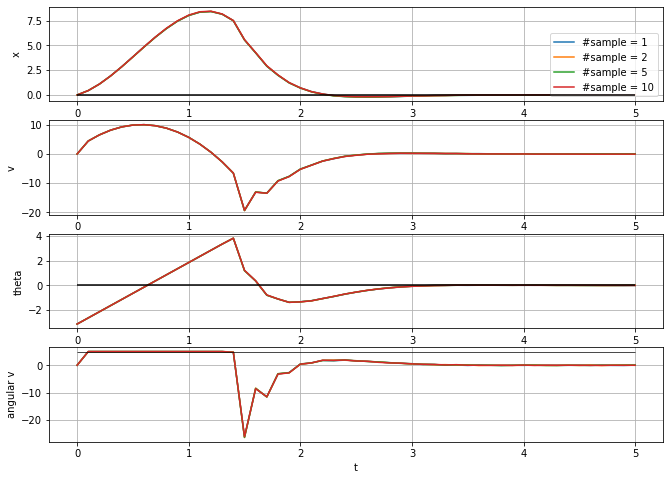

In [1104]:
fig = plt.figure(figsize=(11, 8))
spec=fig.add_gridspec(nrows=4,ncols=1,height_ratios=[1,1,1,1])

ax1 = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[1,0])
ax3 = fig.add_subplot(spec[2,0])
ax4 = fig.add_subplot(spec[3,0])

legend = []

Nt = np.shape(test1_N1_ave[::4])[0]
t_plot = [delta_t*i for i in range(Nt)]



plot_x = [test1_N1_ave[::4]]+[test1_N2_ave[::4]]+[test1_N5_ave[::4]]+[test1_N10_ave[::4]]
plot_v = [test1_N1_ave[1::4]]+[test1_N2_ave[1::4]]+[test1_N5_ave[1::4]]+[test1_N10_ave[1::4]]
plot_th = [test1_N1_ave[2::4]]+[test1_N2_ave[2::4]]+[test1_N5_ave[2::4]]+[test1_N10_ave[2::4]]
plot_thv = [test1_N1_ave[3::4]]+[test1_N2_ave[3::4]]+[test1_N5_ave[3::4]]+[test1_N10_ave[3::4]]
N_plot = len(plot_x)


ax1.plot(t_plot, plot_x[0],label='#sample = 1')
ax1.plot(t_plot, plot_x[1],label='#sample = 2')
ax1.plot(t_plot, plot_x[2],label='#sample = 5')
ax1.plot(t_plot, plot_x[3],label='#sample = 10')
ax1.hlines(0,0,5, zorder=10)

ax1.set_ylabel('x')
ax1.grid(True)
ax1.legend(loc="lower right")



for i in range(4):
    ax2.plot(t_plot, plot_v[i])
ax2.set_ylabel('v')
ax2.grid(True)

for i in range(4):
    ax3.plot(t_plot, plot_th[i])
ax3.set_ylabel('theta')
ax3.hlines(0,0,5, zorder=10)
ax3.grid(True)

for i in range(4):
    ax4.plot(t_plot, plot_thv[i])
ax4.hlines(i_state_ub,0,5, zorder=10,linewidth=0.7)
ax4.set_ylabel('angular v')
ax4.set_xlabel('t')
ax4.grid(True)


plt.show()


save_path = "/Users/zhengangzhong/Dropbox/PhD/documents/slides/DRO3/fig/IP_test1.pdf"
fig.savefig(save_path,bbox_inches='tight')


#### Test 2 fix #sample compare epsilon:

beta = 0.95, N_sample = 2 i_th_state = 3, i_state_ub = 5, epsilon = 0.1,1,10,100 sin_const = 2

In [1064]:
mu =np.zeros([d,1])
mu_w = np.vstack([1]+ [mu] * N)
M_w = mu_w @ mu_w.T + np.diag([0] + [1] * N * d)
beta = 0.95
N_sample = 2
i_th_state = 3
i_state_ub = 5
epsilon = 0.1
sin_const = 2
N_sim = 50

N_loop = 5

In [1065]:
test2_matrix_eps_1em1 = []
for i in range(N_loop):
    sim_temp = simulation(Ak, Bk, Ck, D, E, xk, N, n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, delta_t, x_init, 
               i_state_ub = i_state_ub, beta = beta, i_th_state = i_th_state, 
               epsilon = epsilon, sin_const = sin_const, N_sample = N_sample, N_sim = N_sim)
    test2_matrix_eps_1em1 += [sim_temp]

In [1066]:
epsilon = 1
test2_matrix_eps_1e0 = []
for i in range(N_loop):
    sim_temp = simulation(Ak, Bk, Ck, D, E, xk, N, n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, delta_t, x_init, 
               i_state_ub = i_state_ub, beta = beta, i_th_state = i_th_state, 
               epsilon = epsilon, sin_const = sin_const, N_sample = N_sample, N_sim = N_sim)
    test2_matrix_eps_1e0 += [sim_temp]

In [1067]:
epsilon = 10
test2_matrix_eps_1e1 = []
for i in range(N_loop):
    sim_temp = simulation(Ak, Bk, Ck, D, E, xk, N, n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, delta_t, x_init, 
               i_state_ub = i_state_ub, beta = beta, i_th_state = i_th_state, 
               epsilon = epsilon, sin_const = sin_const, N_sample = N_sample, N_sim = N_sim)
    test2_matrix_eps_1e1 += [sim_temp]

In [1068]:
epsilon = 100
test2_matrix_eps_1e2 = []
for i in range(N_loop):
    sim_temp = simulation(Ak, Bk, Ck, D, E, xk, N, n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, delta_t, x_init, 
               i_state_ub = i_state_ub, beta = beta, i_th_state = i_th_state, 
               epsilon = epsilon, sin_const = sin_const, N_sample = N_sample, N_sim = N_sim)
    test2_matrix_eps_1e2 += [sim_temp]

In [1069]:
test2_eps_1em1_ave = 0
test2_eps_1e0_ave = 0
test2_eps_1e1_ave = 0
test2_eps_1e2_ave = 0

test2_eps_1em1_ave = np.sum(np.array(test2_matrix_eps_1em1),axis=0)
test2_eps_1e0_ave = np.sum(np.array(test2_matrix_eps_1e0),axis=0)
test2_eps_1e1_ave = np.sum(np.array(test2_matrix_eps_1e1),axis=0)
test2_eps_1e2_ave = np.sum(np.array(test2_matrix_eps_1e2),axis=0)

test2_eps_1em1_ave = test2_eps_1em1_ave / N_loop
test2_eps_1e0_ave = test2_eps_1e0_ave / N_loop
test2_eps_1e1_ave = test2_eps_1e1_ave / N_loop
test2_eps_1e2_ave = test2_eps_1e2_ave / N_loop

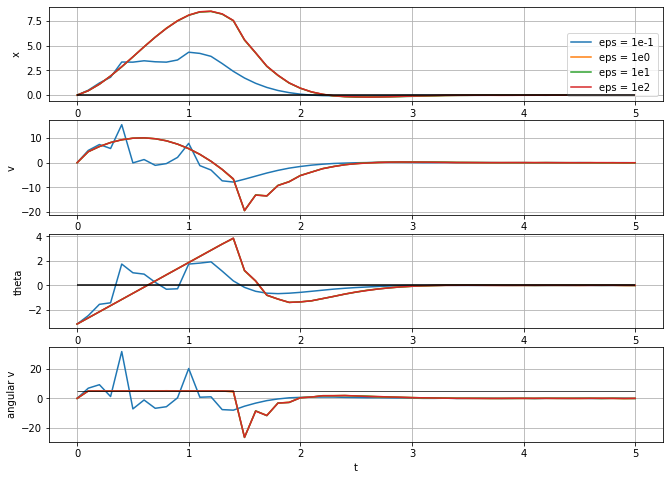

In [1105]:
fig = plt.figure(figsize=(11, 8))
spec=fig.add_gridspec(nrows=4,ncols=1,height_ratios=[1,1,1,1])

ax1 = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[1,0])
ax3 = fig.add_subplot(spec[2,0])
ax4 = fig.add_subplot(spec[3,0])

legend = []

Nt = np.shape(test2_eps_1em1_ave[::4])[0]
t_plot = [delta_t*i for i in range(Nt)]



plot_x = [test2_eps_1em1_ave[::4]]+[test2_eps_1e0_ave[::4]]+[test2_eps_1e1_ave[::4]]+[test2_eps_1e2_ave[::4]]
plot_v = [test2_eps_1em1_ave[1::4]]+[test2_eps_1e0_ave[1::4]]+[test2_eps_1e1_ave[1::4]]+[test2_eps_1e2_ave[1::4]]
plot_th = [test2_eps_1em1_ave[2::4]]+[test2_eps_1e0_ave[2::4]]+[test2_eps_1e1_ave[2::4]]+[test2_eps_1e2_ave[2::4]]
plot_thv = [test2_eps_1em1_ave[3::4]]+[test2_eps_1e0_ave[3::4]]+[test2_eps_1e1_ave[3::4]]+[test2_eps_1e2_ave[3::4]]
N_plot = len(plot_x)


ax1.plot(t_plot, plot_x[0],label='eps = 1e-1')
ax1.plot(t_plot, plot_x[1],label='eps = 1e0')
ax1.plot(t_plot, plot_x[2],label='eps = 1e1')
ax1.plot(t_plot, plot_x[3],label='eps = 1e2')
ax1.hlines(0,0,5, zorder=10)

ax1.set_ylabel('x')
ax1.grid(True)
ax1.legend(loc="lower right")



for i in range(4):
    ax2.plot(t_plot, plot_v[i])
ax2.set_ylabel('v')
ax2.grid(True)

for i in range(4):
    ax3.plot(t_plot, plot_th[i])
ax3.set_ylabel('theta')
ax3.hlines(0,0,5, zorder=10)
ax3.grid(True)

for i in range(4):
    ax4.plot(t_plot, plot_thv[i])
ax4.hlines(i_state_ub,0,5, zorder=10,linewidth=0.7)
ax4.set_ylabel('angular v')
ax4.set_xlabel('t')
ax4.grid(True)


plt.show()


save_path = "/Users/zhengangzhong/Dropbox/PhD/documents/slides/DRO3/fig/IP_test2.pdf"
fig.savefig(save_path,bbox_inches='tight')


#### Test 3 fix epsiolon, compare #sample:
beta = 0.95, N_sample = 1,2,5,10 i_th_state = 3, i_state_ub = 5, epsilon = 1, sin_const = 2,

In [1085]:
mu =np.zeros([d,1])
mu_w = np.vstack([1]+ [mu] * N)
M_w = mu_w @ mu_w.T + np.diag([0] + [1] * N * d)
beta = 0.95
N_sample = 1
i_th_state = 3
i_state_ub = 5
epsilon = 1
sin_const = 2
N_sim = 50

N_loop = 5

In [1086]:
test3_matrix_N1 = []
for i in range(N_loop):
    sim_temp = simulation(Ak, Bk, Ck, D, E, xk, N, n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, delta_t, x_init, 
               i_state_ub = i_state_ub, beta = beta, i_th_state = i_th_state, 
               epsilon = epsilon, sin_const = sin_const, N_sample = N_sample, N_sim = N_sim)
    test3_matrix_N1 += [sim_temp]

In [1087]:
N_sample = 2
test3_matrix_N2 = []
for i in range(N_loop):
    sim_temp = simulation(Ak, Bk, Ck, D, E, xk, N, n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, delta_t, x_init, 
               i_state_ub = i_state_ub, beta = beta, i_th_state = i_th_state, 
               epsilon = epsilon, sin_const = sin_const, N_sample = N_sample, N_sim = N_sim)
    test3_matrix_N2 += [sim_temp]

In [1088]:
N_sample = 5
test3_matrix_N5 = []
for i in range(N_loop):
    sim_temp = simulation(Ak, Bk, Ck, D, E, xk, N, n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, delta_t, x_init, 
               i_state_ub = i_state_ub, beta = beta, i_th_state = i_th_state, 
               epsilon = epsilon, sin_const = sin_const, N_sample = N_sample, N_sim = N_sim)
    test3_matrix_N5 += [sim_temp]

In [1089]:
N_sample = 10
test3_matrix_N10 = []
for i in range(N_loop):
    sim_temp = simulation(Ak, Bk, Ck, D, E, xk, N, n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, delta_t, x_init, 
               i_state_ub = i_state_ub, beta = beta, i_th_state = i_th_state, 
               epsilon = epsilon, sin_const = sin_const, N_sample = N_sample, N_sim = N_sim)
    test3_matrix_N10 += [sim_temp]

In [1090]:
test3_N1_ave = 0
test3_N2_ave = 0
test3_N5_ave = 0
test3_N10_ave = 0

test3_N1_ave = np.sum(np.array(test3_matrix_N1),axis=0)
test3_N2_ave = np.sum(np.array(test3_matrix_N2),axis=0)
test3_N5_ave = np.sum(np.array(test3_matrix_N5),axis=0)
test3_N10_ave = np.sum(np.array(test3_matrix_N10),axis=0)

test3_N1_ave = test3_N1_ave / N_loop
test3_N2_ave = test3_N2_ave / N_loop
test3_N5_ave = test3_N5_ave / N_loop
test3_N10_ave = test3_N10_ave / N_loop

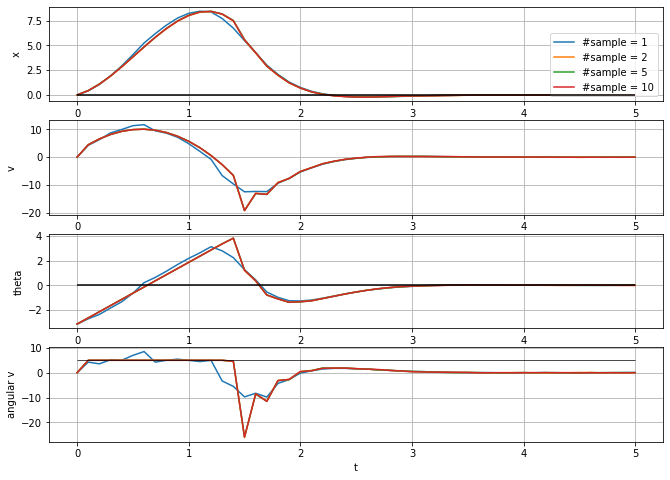

In [1106]:
fig = plt.figure(figsize=(11, 8))
spec=fig.add_gridspec(nrows=4,ncols=1,height_ratios=[1,1,1,1])

ax1 = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[1,0])
ax3 = fig.add_subplot(spec[2,0])
ax4 = fig.add_subplot(spec[3,0])

legend = []

Nt = np.shape(test3_N1_ave[::4])[0]
t_plot = [delta_t*i for i in range(Nt)]



plot_x = [test3_N1_ave[::4]]+[test3_N2_ave[::4]]+[test3_N5_ave[::4]]+[test3_N10_ave[::4]]
plot_v = [test3_N1_ave[1::4]]+[test3_N2_ave[1::4]]+[test3_N5_ave[1::4]]+[test3_N10_ave[1::4]]
plot_th = [test3_N1_ave[2::4]]+[test3_N2_ave[2::4]]+[test3_N5_ave[2::4]]+[test3_N10_ave[2::4]]
plot_thv = [test3_N1_ave[3::4]]+[test3_N2_ave[3::4]]+[test3_N5_ave[3::4]]+[test3_N10_ave[3::4]]
N_plot = len(plot_x)


ax1.plot(t_plot, plot_x[0],label='#sample = 1')
ax1.plot(t_plot, plot_x[1],label='#sample = 2')
ax1.plot(t_plot, plot_x[2],label='#sample = 5')
ax1.plot(t_plot, plot_x[3],label='#sample = 10')
ax1.hlines(0,0,5, zorder=10)

ax1.set_ylabel('x')
ax1.grid(True)
ax1.legend(loc="lower right")



for i in range(4):
    ax2.plot(t_plot, plot_v[i])
ax2.set_ylabel('v')
ax2.grid(True)

for i in range(4):
    ax3.plot(t_plot, plot_th[i])
ax3.set_ylabel('theta')
ax3.hlines(0,0,5, zorder=10)
ax3.grid(True)

for i in range(4):
    ax4.plot(t_plot, plot_thv[i])
ax4.hlines(i_state_ub,0,5, zorder=10,linewidth=0.7)
ax4.set_ylabel('angular v')
ax4.set_xlabel('t')
ax4.grid(True)


plt.show()


save_path = "/Users/zhengangzhong/Dropbox/PhD/documents/slides/DRO3/fig/IP_test3.pdf"
fig.savefig(save_path,bbox_inches='tight')


In [1081]:
sim1_temp = simulation(Ak, Bk, Ck, D, E, xk, N, n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, delta_t, x_init, 
               i_state_ub = i_state_ub, beta = beta, i_th_state = i_th_state, 
               epsilon = epsilon, sin_const = sin_const, N_sample = N_sample, N_sim = N_sim)

In [1082]:
sim1_temp

[0.0,
 0.0,
 -3.141592653589793,
 0.0,
 0.46092904805160356,
 4.6092904805160355,
 -2.5895326029863037,
 5.520600506034892,
 1.1311313786067836,
 6.842813805262363,
 -1.9526197653323103,
 6.369128376539933,
 1.930314380001179,
 7.828805184851817,
 -1.4258440618671624,
 5.2677570346514795,
 2.7893747765151837,
 8.636710805245547,
 -0.9258440360124364,
 5.000000258547264,
 3.98435712836447,
 11.750800889617723,
 0.5487216643746992,
 14.745657003871361,
 4.508778082890745,
 5.275501301418691,
 0.40025477712218693,
 -1.4846688725251305,
 5.180104729144567,
 6.822615208887186,
 0.9002548949528558,
 5.00000117830669,
 5.705209644470825,
 5.448964333991049,
 1.4002547571165362,
 4.999998621636805,
 6.050439060656766,
 3.5847844211670745,
 1.90024372860174,
 4.999889714852038,
 6.154271931840877,
 1.2302266678982305,
 2.4002581908711793,
 5.000144622694394,
 5.964419184497946,
 -1.7560903848507972,
 2.8492554657387443,
 4.489972748675644,
 5.2729232084135145,
 -6.982417914793828,
 2.5787179263

In [ ]:
sim1_N2

In [46]:
sim2_N2 = simulation(Ak, Bk, Ck, D, E, xk, N, n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, delta_t, x_init, 
               i_state_ub = i_state_ub, beta = beta, i_th_state = i_th_state, 
               epsilon = epsilon, sin_const = sin_const, N_sample = N_sample, N_sim = N_sim)

In [47]:
sim3_N2 = simulation(Ak, Bk, Ck, D, E, xk, N, n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, delta_t, x_init, 
               i_state_ub = i_state_ub, beta = beta, i_th_state = i_th_state, 
               epsilon = epsilon, sin_const = sin_const, N_sample = N_sample, N_sim = N_sim)

In [48]:
sim4_N2 = simulation(Ak, Bk, Ck, D, E, xk, N, n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, delta_t, x_init, 
               i_state_ub = i_state_ub, beta = beta, i_th_state = i_th_state, 
               epsilon = epsilon, sin_const = sin_const, N_sample = N_sample, N_sim = N_sim)

In [49]:
sim5_N2 = simulation(Ak, Bk, Ck, D, E, xk, N, n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, delta_t, x_init, 
               i_state_ub = i_state_ub, beta = beta, i_th_state = i_th_state, 
               epsilon = epsilon, sin_const = sin_const, N_sample = N_sample, N_sim = N_sim)

In [50]:
print(np.shape(sim1_N2),np.shape(sim2_N2),np.shape(sim3_N2),np.shape(sim4_N2),np.shape(sim5_N2))

(162,) (162,) (162,) (162,) (162,)


In [51]:
sim_ave_N2 = (np.array(sim1_N2)+np.array(sim2_N2)+np.array(sim3_N2)+np.array(sim4_N2)+np.array(sim5_N2))/5

print(sim_ave_N2)

[-2.00000000e+00  0.00000000e+00 -1.98767445e+00  2.40296906e-01
 -1.95341677e+00  4.25662948e-01 -1.90768083e+00  4.82261764e-01
 -1.85796359e+00  5.04865932e-01 -1.80655227e+00  5.08022937e-01
 -1.75519558e+00  5.31984744e-01 -1.70463719e+00  4.69812208e-01
 -1.65494509e+00  5.14145179e-01 -1.60358751e+00  4.96991116e-01
 -1.55437806e+00  4.82421457e-01 -1.50523269e+00  5.11164856e-01
 -1.45312558e+00  5.31782060e-01 -1.40123253e+00  5.10349445e-01
 -1.34990364e+00  5.01003493e-01 -1.29876493e+00  5.08084560e-01
 -1.24831388e+00  5.13662015e-01 -1.19812289e+00  4.80974158e-01
 -1.14813151e+00  5.06019675e-01 -1.09631931e+00  5.03466056e-01
 -1.04578521e+00  5.01425435e-01 -9.96548113e-01  4.99949790e-01
 -9.46978829e-01  5.03306045e-01 -8.96099262e-01  5.04302999e-01
 -8.45194964e-01  5.01942685e-01 -7.93943337e-01  5.03529257e-01
 -7.43644527e-01  5.03925192e-01 -6.93761760e-01  5.01222367e-01
 -6.44160151e-01  5.01595641e-01 -5.94176735e-01  5.01524898e-01
 -5.43561060e-01  4.96520

In [997]:
mu =np.zeros([d,1])
mu_w = np.vstack([1]+ [mu] * N)
M_w = mu_w @ mu_w.T + np.diag([0] + [1] * N * d)

beta = 0.95
N_sample = 5
i_th_state = 1
i_state_ub = 6
epsilon = 1
sin_const = 2
N_sim = 50

In [998]:
sim1 = simulation(Ak, Bk, Ck, D, E, xk, N, n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, delta_t, x_init, 
               i_state_ub = i_state_ub, beta = beta, i_th_state = i_th_state, 
               epsilon = epsilon, sin_const = sin_const, N_sample = N_sample, N_sim = N_sim)

[[ 0.        ]
 [ 0.        ]
 [-3.14159265]
 [ 0.        ]] [[70.02589073]]
[[ 0.58956055]
 [ 5.99999998]
 [-2.08687374]
 [10.54718912]] [[1.59728081]]
[[ 1.18203414]
 [ 6.00000002]
 [-1.39812928]
 [ 6.88744466]] [[1.28541695]]
[[ 1.763927  ]
 [ 6.00000009]
 [-0.96091364]
 [ 4.37215637]] [[1.10600248]]
[[ 2.35534901]
 [ 6.00000002]
 [-0.70938731]
 [ 2.51526324]] [[1.04239059]]
[[ 2.97436179]
 [ 6.        ]
 [-0.62020624]
 [ 0.89181073]] [[1.11308292]]
[[ 3.59431286]
 [ 6.        ]
 [-0.71931247]
 [-0.99106229]] [[1.39076618]]
[[ 4.19208863]
 [ 6.00000002]
 [-1.10860805]
 [-3.89295575]] [[2.04729233]]
[[ 4.8118398 ]
 [ 6.        ]
 [-2.02902013]
 [-9.20412088]] [[3.44977681]]
[[  5.41475888]
 [  6.        ]
 [ -3.9952219 ]
 [-19.66201765]] [[6.36000404]]
[[  5.99560112]
 [  6.00000043]
 [ -8.07518468]
 [-40.79962782]] [[12.34444483]]
[[  6.57608382]
 [  6.        ]
 [-16.46503737]
 [-83.89852691]] [[24.61509357]]
[[   7.17216439]
 [   6.00000001]
 [ -33.66776842]
 [-172.02731047]] [[49

ValueError: Cannot unpack invalid solution: Solution(status=UNKNOWN, opt_val=nan, primal_vars={}, dual_vars={}, attr={'solve_time': 0.11739492416381836})

In [907]:
sim1

[0.0,
 0.0,
 -3.141592653589793,
 0.0,
 0.6199999180495357,
 6.199999180495356,
 -2.0145859128279464,
 11.270067407618466,
 1.2534851790718868,
 6.200000246030864,
 -1.202290590426903,
 8.122953224010438,
 1.8716624128128707,
 6.19999971494208,
 -0.5282773372679778,
 6.740132531589256,
 2.502610705269264,
 6.480015529788426,
 0.2986190497750242,
 8.268963870430023,
 3.1138175994867066,
 6.200000561503251,
 1.4233842922465338,
 11.2476524247151,
 3.6117408195041616,
 5.166320153108223,
 3.078041059708204,
 16.546567674616703,
 2.6958732078810437,
 -9.065073220923786,
 1.2669825169840756,
 -18.11058542724129,
 2.2690314039156076,
 -4.227262785744349,
 1.0115902421643557,
 -2.553922748197195,
 1.6014845607793444,
 -6.726088945768453,
 0.12114831405425852,
 -8.904419281100978,
 1.2011925094205886,
 -4.060930280656647,
 -0.07876800768185055,
 -1.9991632173610938,
 0.7838639352263418,
 -4.121058797958517,
 -0.39923121571086173,
 -3.204632080290114,
 0.5078142714622611,
 -2.655959958116755,
 

In [ ]:
np.shape(sim1[::2])[0]

In [204]:
LQR_pos

(81,)

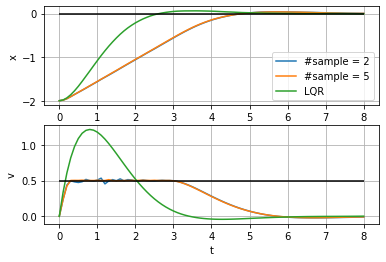

In [205]:
plt.figure(1)
plt.clf()
legend = []

Nt = np.shape(sim1[::2])[0]
t_plot = [delta_t*i for i in range(Nt)]

x_LQR_array = np.array(x_LQR)

LQR_pos = x_LQR_array[:,0]
LQR_v = x_LQR_array[:,1]

plot_x = [sim_ave_N2[::2]]+[sim_ave_N5[::2]]
plot_v = [sim_ave_N2[1::2]]+[sim_ave_N5[1::2]]
N_plot = len(plot_x)

plt.subplot( str(2) + str(1) + str(1) )
plt.plot(t_plot, plot_x[0])
legend += ['#sample = 2']
plt.plot(t_plot, plot_x[1])
legend += ['#sample = 5']
plt.plot(t_plot, LQR_pos)
legend += ['LQR']
plt.hlines(0,0,8, zorder=10)

plt.ylabel('x')
plt.grid()
plt.legend(legend)


plt.subplot( str(2) + str(1) + str(2) )
plt.plot(t_plot, plot_v[0])
plt.plot(t_plot, plot_v[1])
plt.plot(t_plot, LQR_v)
plt.hlines(i_state_ub,0,8, zorder=10)
plt.ylabel('v')


plt.xlabel('t')
plt.grid()
plt.show()


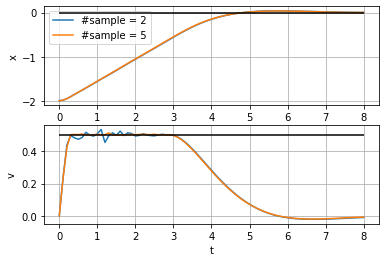

In [206]:
plt.figure(1)
plt.clf()
legend = []

Nt = np.shape(sim1[::2])[0]
t_plot = [delta_t*i for i in range(Nt)]

x_LQR_array = np.array(x_LQR)

LQR_pos = x_LQR_array[:,0]
LQR_v = x_LQR_array[:,1]

plot_x = [sim_ave_N2[::2]]+[sim_ave_N5[::2]]
plot_v = [sim_ave_N2[1::2]]+[sim_ave_N5[1::2]]
N_plot = len(plot_x)

plt.subplot( str(2) + str(1) + str(1) )
plt.plot(t_plot, plot_x[0])
legend += ['#sample = 2']
plt.plot(t_plot, plot_x[1])
legend += ['#sample = 5']
plt.hlines(0,0,8, zorder=10)

plt.ylabel('x')
plt.grid()
plt.legend(legend)


plt.subplot( str(2) + str(1) + str(2) )
plt.plot(t_plot, plot_v[0])
plt.plot(t_plot, plot_v[1])
plt.hlines(i_state_ub,0,8, zorder=10)
plt.ylabel('v')


plt.xlabel('t')
plt.grid()
plt.show()


In [ ]:
plt.figure(1)
plt.clf()
legend = []

Nt = np.shape(sim1[::2])[0]
t_plot = [delta_t*i for i in range(Nt)]

plot_x = [sim1[::2]]+[sim2[::2]]+[sim3[::2]]+[sim4[::2]]+[sim5[::2]]
plot_v = [sim1[1::2]]+[sim2[1::2]]+[sim3[1::2]]+[sim4[1::2]]+[sim5[1::2]]
N_plot = len(plot_x)



plt.subplot( str(2) + str(1) + str(1) )
for i in range (N_plot):
    plt.plot(t_plot, plot_x[i])
    legend += ['x'+ str(i)]
plt.ylabel('x')
plt.grid()
plt.legend(legend)
plt.subplot( str(2) + str(1) + str(2) )
for i in range (N_plot):
    plt.plot(t_plot, plot_v[i])
plt.ylabel('v')


plt.xlabel('t')
plt.grid()
plt.show()


In [ ]:
def plot_single(self):
    # Plot the solution
    Nx = self.Nx
    Nu = self.Nu
    delta_t = self.delta_t
    N_sim = self.N_sim

    tgrid = [delta_t * k for k in range(N_sim + 1)]

    plt.figure(1)
    plt.clf()

    legend = []
    for i in range (Nx):
        x_opt = self.x_opt[i::Nx]
        plt.plot(tgrid, x_opt)
        legend += ['x'+ str(i)]

    for i in range (Nu):
        u_opt = self.u_opt[i::Nu]
        plt.step(tgrid, ca.vertcat(ca.DM.nan(1), u_opt))
        legend += ['u'+ str(i)]
    plt.xlabel('t')

    plt.legend(legend)
    plt.grid()
    plt.show()

In [39]:
N_sim = 80

t0 = 0

xk = x_init
uk = 0
t = t0
h = delta_t

x_list = []
x_list += xk.flatten().tolist()
u_list = []

N_round = 20

state_ave = 0
for j in range(N_round):
    xk = x_init
    uk = 0
    h = delta_t

    x_list = []
    x_list += xk.flatten().tolist()
    u_list = []
    for i in range(N_sim):
    #     if i % N == 0:
        n, m, d, r, Nx, Nu, Ny, Nw, Ax, Bx, Cx, Ay, By, Cy, Ey, Cx_tilde, Cy_tilde, Ey_tilde, D_tilde  = stack_system(Ak, Bk, Ck, D, E, xk, N)
        Jx, Ju, eigval,eigvec, H_cal_dec, H, H_new_matrix, H_new, loss_func, W_sample_matrix, W_sample_matrix_ext, lambda_var, gamma_matrix, si_var, constraint = define_obj(n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, beta = beta, N_sample = N_sample, i_th_state = i_th_state, i_state_ub = i_state_ub, epsilon = epsilon)
        obj = cp.Minimize(loss_func)
        prob = cp.Problem(obj,constraint)
    #         print(W_sample_matrix)
    #     print( prob.solve(verbose=True))
        prob.solve()
    #         print(Ax @ x_init +  Bx @ H.value @ W_sample_matrix_ext[:,0:1]  + Cx @ W_sample_matrix[:,0:1])
    #     print("status:", prob.status)
    #         print("Controller", H_cal_dec.value[0,0], H_cal_dec.value[0,1])
    #         print("lambda",lambda_var.value)
    #         print("si",si_var.value)
    #     print("state_constraint", np.sum(si_var.value)/N_sample + lambda_var.value * epsilon)

        wk = sin_const * np.sin(np.random.randn(d,1))
        uk = H_cal_dec.value[0,0] + H_cal_dec.value[0,1] * (D @ xk + E @ wk)
        u_list +=  uk.flatten().tolist() 
        print(xk,uk)
        x_kp1 = RK4_np(mass_string_ode, xk, uk, t, h)
        x_list += x_kp1.flatten().tolist()
        xk = x_kp1
        xk += Ck @ wk
    if j > 0:
        state_ave = (state_ave * j + xk) / (j+1)
    else:
        state_ave = xk

[[-2]
 [ 0]] [[1.14779147]]
[[-1.98648521]
 [ 0.23861756]] [[0.20090857]]
[[-1.95531359]
 [ 0.39777411]] [[-0.2729577]]
[[-1.90828088]
 [ 0.50918638]] [[-2.40203339]]
[[-1.85915063]
 [ 0.50152573]] [[-2.15051483]]
[[-1.80963693]
 [ 0.50207084]] [[-2.06008965]]
[[-1.75769986]
 [ 0.5021388 ]] [[-1.96507706]]
[[-1.70895364]
 [ 0.50178623]] [[-2.83299765]]
[[-1.6615731]
 [ 0.4567342]] [[-2.0015528]]
[[-1.61808124]
 [ 0.45230913]] [[-0.68240433]]
[[-1.56974308]
 [ 0.50563547]] [[-1.01899401]]
[[-1.51696262]
 [ 0.53120931]] [[-2.0542583]]
[[-1.46361921]
 [ 0.50022413]] [[-1.32987583]]
[[-1.41157361]
 [ 0.50232738]] [[-1.26654797]]
[[-1.35931974]
 [ 0.50223863]] [[-0.94165915]]
[[-1.31044504]
 [ 0.51237805]] [[-1.26646523]]
[[-1.26008132]
 [ 0.50147239]] [[-0.94807526]]
[[-1.21150382]
 [ 0.50222453]] [[-0.90754494]]
[[-1.16237811]
 [ 0.50024375]] [[-0.73402282]]
[[-1.11197229]
 [ 0.50203689]] [[-0.6671271]]
[[-1.06275561]
 [ 0.50200003]] [[-0.56725153]]
[[-1.01143153]
 [ 0.50203533]] [[-0.460

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


[[-1.95367038]
 [ 0.43076823]] [[-0.94895828]]
[[-1.90742574]
 [ 0.50594818]] [[-2.3335197]]
[[-1.85636338]
 [ 0.5018498 ]] [[-2.1493202]]
[[-1.80472129]
 [ 0.50214528]] [[-2.39991997]]
[[-1.75634606]
 [ 0.48599454]] [[-1.63155888]]
[[-1.70694068]
 [ 0.50329795]] [[-1.40066702]]
[[-1.65402707]
 [ 0.52423527]] [[-2.19507936]]
[[-1.60186741]
 [ 0.50043233]] [[-1.61256334]]
[[-1.55325585]
 [ 0.50221866]] [[-1.55603564]]
[[-1.50116709]
 [ 0.50186171]] [[-1.66333996]]
[[-1.45221564]
 [ 0.4917532 ]] [[-1.14104384]]
[[-1.40266744]
 [ 0.50277052]] [[-1.26405584]]
[[-1.35175232]
 [ 0.50190789]] [[-1.13832766]]
[[-1.29973672]
 [ 0.50227708]] [[-1.01727224]]
[[-1.24987793]
 [ 0.5033823 ]] [[-0.96858385]]
[[-1.19872641]
 [ 0.5019632 ]] [[-0.83580865]]
[[-1.14935961]
 [ 0.50216067]] [[-0.74493639]]
[[-1.10070791]
 [ 0.50196534]] [[-0.70695263]]
[[-1.05164692]
 [ 0.49904844]] [[-0.48679726]]
[[-1.00353514]
 [ 0.5022077 ]] [[-0.45034202]]
[[-0.9519689 ]
 [ 0.50214214]] [[-0.34675062]]
[[-0.90034124]


[[-1.07710883]
 [ 0.50288225]] [[-0.65757035]]
[[-1.02737234]
 [ 0.49993473]] [[-0.45382503]]
[[-0.97752972]
 [ 0.50224448]] [[-0.39494393]]
[[-0.92925638]
 [ 0.50233064]] [[-0.3078618]]
[[-0.87767635]
 [ 0.5019657 ]] [[-0.19485372]]
[[-0.82921508]
 [ 0.50210973]] [[-0.10019358]]
[[-0.77696134]
 [ 0.50212818]] [[0.00404834]]
[[-0.72654266]
 [ 0.50213166]] [[0.10334523]]
[[-0.67771087]
 [ 0.50206324]] [[0.20467382]]
[[-0.62881974]
 [ 0.50217454]] [[0.28676621]]
[[-0.57828186]
 [ 0.50154256]] [[0.24989456]]
[[-0.52929753]
 [ 0.49460714]] [[0.21635658]]
[[-0.48236371]
 [ 0.48257336]] [[0.18609781]]
[[-0.43305534]
 [ 0.46651654]] [[0.15549588]]
[[-0.38611958]
 [ 0.44677922]] [[0.12791635]]
[[-0.34363019]
 [ 0.42425075]] [[0.10457132]]
[[-0.30258601]
 [ 0.39994106]] [[0.08290684]]
[[-0.26391275]
 [ 0.37431817]] [[0.0634395]]
[[-0.22592323]
 [ 0.3478926 ]] [[0.04475314]]
[[-0.19132773]
 [ 0.32087937]] [[0.02876235]]
[[-0.16074357]
 [ 0.2938026 ]] [[0.01573774]]
[[-0.13199446]
 [ 0.26718079]]

[[-0.21340419]
 [ 0.33796249]] [[0.03902046]]
[[-0.18280469]
 [ 0.31095103]] [[0.02596186]]
[[-0.15191192]
 [ 0.28438215]] [[0.01253401]]
[[-0.12286264]
 [ 0.25814788]] [[0.00034273]]
[[-0.09993591]
 [ 0.23242834]] [[-0.00753411]]
[[-0.07963186]
 [ 0.20791707]] [[-0.01390653]]
[[-0.06200476]
 [ 0.1847532 ]] [[-0.01878311]]
[[-0.04593724]
 [ 0.16306045]] [[-0.02302697]]
[[-0.02953568]
 [ 0.14280117]] [[-0.02801482]]
[[-0.01423454]
 [ 0.12370374]] [[-0.03259933]]
[[-0.00477136]
 [ 0.10572179]] [[-0.03328732]]
[[0.00452241]
 [0.08941673]] [[-0.0344345]]
[[0.01264088]
 [0.07454182]] [[-0.03521674]]
[[0.01953542]
 [0.06101725]] [[-0.0355706]]
[[0.02530419]
 [0.04878215]] [[-0.03554693]]
[[0.0300061 ]
 [0.03777294]] [[-0.03516683]]
[[0.03521048]
 [0.02792874]] [[-0.03556092]]
[[0.03701118]
 [0.01899954]] [[-0.03377532]]
[[0.03870607]
 [0.01127032]] [[-0.03232964]]
[[0.0410355 ]
 [0.00456257]] [[-0.03170512]]
[[ 0.03965705]
 [-0.0013675 ]] [[-0.02862988]]
[[ 0.03760129]
 [-0.0061744 ]] [[-0.0

[[0.04125327]
 [0.00850605]] [[-0.03323721]]
[[0.04354544]
 [0.00191763]] [[-0.03262687]]
[[ 0.04144982]
 [-0.00390747]] [[-0.02906179]]
[[ 0.04229515]
 [-0.00853531]] [[-0.02807565]]
[[ 0.04042335]
 [-0.01253025]] [[-0.02530787]]
[[ 0.03867931]
 [-0.01564883]] [[-0.02294264]]
[[ 0.0389771 ]
 [-0.01804759]] [[-0.02232648]]
[[ 0.03639984]
 [-0.02010042]] [[-0.01972059]]
[[ 0.03416271]
 [-0.0214983 ]] [[-0.01759224]]
[[ 0.03109393]
 [-0.02238909]] [[-0.01503381]]
[[ 0.03081762]
 [-0.02274868]] [[-0.01470589]]
[[ 0.02990295]
 [-0.02301574]] [[-0.01393781]]
[[ 0.02814208]
 [-0.02312399]] [[-0.0126116]]
[[ 0.02522015]
 [-0.02299196]] [[-0.01051303]]
[[ 0.02463689]
 [-0.02251076]] [[-0.0102524]]
[[ 0.02040971]
 [-0.0220326 ]] [[-0.0073163]]
[[ 0.02016058]
 [-0.02109523]] [[-0.00745964]]
[[ 0.01724307]
 [-0.02027621]] [[-0.00560337]]
[[ 0.01688985]
 [-0.01921847]] [[-0.00571221]]
[[ 0.01370057]
 [-0.01828514]] [[-0.00369624]]
[[ 0.01262719]
 [-0.01709692]] [[-0.00332192]]
[[ 0.00937296]
 [-0.

[[ 0.01609081]
 [-0.01779096]] [[-0.00562251]]
[[ 0.01632147]
 [-0.0169847 ]] [[-0.00607235]]
[[ 0.01267707]
 [-0.01633662]] [[-0.00362311]]
[[ 0.01043572]
 [-0.01533036]] [[-0.00232826]]
[[ 0.00734533]
 [-0.014201  ]] [[-0.00044933]]
[[ 0.00777177]
 [-0.01286047]] [[-0.00123252]]
[[-2]
 [ 0]] [[1.15091558]]
[[-1.98575317]
 [ 0.23876238]] [[0.73340962]]
[[-1.95234704]
 [ 0.42251346]] [[-0.92851691]]
[[-1.90740744]
 [ 0.49970542]] [[-2.11534249]]
[[-1.85548334]
 [ 0.5066164 ]] [[-2.28314779]]
[[-1.80437837]
 [ 0.49994142]] [[-2.00965116]]
[[-1.75557384]
 [ 0.50216612]] [[-1.63739718]]
[[-1.70538469]
 [ 0.51680159]] [[-2.14702931]]
[[-1.65258823]
 [ 0.50105622]] [[-1.72458629]]
[[-1.60089814]
 [ 0.50226234]] [[-1.63671359]]
[[-1.54880609]
 [ 0.50257618]] [[-1.56031197]]
[[-1.49675196]
 [ 0.50155707]] [[-1.54653883]]
[[-1.44859599]
 [ 0.49649719]] [[-1.20001782]]
[[-1.40023237]
 [ 0.50376303]] [[-1.27559506]]
[[-1.35132228]
 [ 0.50199704]] [[-1.1367084]]
[[-1.30286362]
 [ 0.5023886 ]] [[-

[[-1.45985484]
 [ 0.5020487 ]] [[-1.5202664]]
[[-1.4094058 ]
 [ 0.49471532]] [[-1.10679806]]
[[-1.35884316]
 [ 0.50292528]] [[-1.30120573]]
[[-1.31082613]
 [ 0.49625556]] [[-0.94873247]]
[[-1.26108909]
 [ 0.50243189]] [[-0.81871944]]
[[-1.20949237]
 [ 0.50913554]] [[-1.00147403]]
[[-1.15821468]
 [ 0.50162045]] [[-0.7523913]]
[[-1.1074491 ]
 [ 0.50197818]] [[-0.6549993]]
[[-1.05631503]
 [ 0.5020926 ]] [[-0.55667337]]
[[-1.00491554]
 [ 0.50200783]] [[-0.45664583]]
[[-0.95402518]
 [ 0.50180678]] [[-0.34459967]]
[[-0.90391255]
 [ 0.50211049]] [[-0.2501732]]
[[-0.85199895]
 [ 0.50210173]] [[-0.14964184]]
[[-0.8007894 ]
 [ 0.50194145]] [[0.00177037]]
[[-0.75122582]
 [ 0.50407522]] [[0.01632116]]
[[-0.70128159]
 [ 0.50198172]] [[0.15772578]]
[[-0.64934942]
 [ 0.50211371]] [[0.25885346]]
[[-0.60087999]
 [ 0.50209987]] [[0.26628621]]
[[-0.54949548]
 [ 0.4979391 ]] [[0.23002098]]
[[-0.50048769]
 [ 0.48793201]] [[0.19753483]]
[[-0.4522302]
 [ 0.4733149]] [[0.16720338]]
[[-0.40584612]
 [ 0.4549201

[[-0.55365331]
 [ 0.49863585]] [[0.23282935]]
[[-0.50506837]
 [ 0.48904419]] [[0.20050973]]
[[-0.45613122]
 [ 0.47482969]] [[0.16953944]]
[[-0.40761908]
 [ 0.45668706]] [[0.14024785]]
[[-0.36341757]
 [ 0.43529846]] [[0.1152496]]
[[-0.32212613]
 [ 0.41172933]] [[0.09314594]]
[[-0.28350216]
 [ 0.38669723]] [[0.07350912]]
[[-0.24525389]
 [ 0.36077419]] [[0.05445814]]
[[-0.2122764 ]
 [ 0.33415034]] [[0.03951929]]
[[-0.18218429]
 [ 0.3076057 ]] [[0.02667064]]
[[-0.15279852]
 [ 0.28149326]] [[0.01418999]]
[[-0.12615812]
 [ 0.25583342]] [[0.00356679]]
[[-0.10139759]
 [ 0.23090169]] [[-0.00593009]]
[[-0.07897531]
 [ 0.20681984]] [[-0.01400658]]
[[-0.05913893]
 [ 0.18374826]] [[-0.02053674]]
[[-0.04182764]
 [ 0.16185307]] [[-0.02562301]]
[[-0.02737294]
 [ 0.1412661 ]] [[-0.02906795]]
[[-0.01555614]
 [ 0.12214013]] [[-0.03108525]]
[[-0.00566981]
 [ 0.10457575]] [[-0.03222911]]
[[0.00321665]
 [0.08856785]] [[-0.03318076]]
[[0.00944361]
 [0.07399419]] [[-0.03267959]]
[[0.01587472]
 [0.06096239]] [

[[-0.00078462]
 [ 0.10336672]] [[-0.03539381]]
[[0.01012785]
 [0.08693311]] [[-0.03768428]]
[[0.01826661]
 [0.07174508]] [[-0.03837246]]
[[0.02467131]
 [0.0579549 ]] [[-0.03827438]]
[[0.02994912]
 [0.04555875]] [[-0.03783433]]
[[0.03502494]
 [0.03447647]] [[-0.03770323]]
[[0.03927564]
 [0.0245235 ]] [[-0.03735953]]
[[0.041317  ]
 [0.01562379]] [[-0.03576082]]
[[0.04433423]
 [0.00788884]] [[-0.03528366]]
[[0.0431903 ]
 [0.00100871]] [[-0.03204993]]
[[ 0.04210294]
 [-0.00462602]] [[-0.0292911]]
[[ 0.04338386]
 [-0.00922169]] [[-0.028632]]
[[ 0.04173059]
 [-0.01324464]] [[-0.0260187]]
[[ 0.03840221]
 [-0.01641462]] [[-0.02247279]]
[[ 0.03845898]
 [-0.01865578]] [[-0.02173457]]
[[ 0.03607517]
 [-0.02054567]] [[-0.01932737]]
[[ 0.03315272]
 [-0.02183119]] [[-0.01673513]]
[[ 0.03248114]
 [-0.02254074]] [[-0.01599916]]
[[ 0.03097375]
 [-0.02305187]] [[-0.01471113]]
[[ 0.02777177]
 [-0.02329005]] [[-0.01228203]]
[[ 0.02656085]
 [-0.02308453]] [[-0.01146481]]
[[ 0.0223148 ]
 [-0.02275842]] [[-0

SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.

In [40]:
state_ave

array([[ 0.00641659],
       [-0.01078767]])

In [99]:
mu =np.zeros([d,1])
mu_w = np.vstack([1]+ [mu] * N)
M_w = mu_w @ mu_w.T + np.diag([0] + [1] * N * d)
beta = 0.95
N_sample = 2
i_th_state = 1 
i_state_ub = 0.5
epsilon = 0.5
sin_const = 2

N_sim = 50

In [62]:
H_cal_dec.value

array([[ 466.37108582,  232.89552982,    0.        ,    0.        ,
           0.        ,    0.        ],
       [  57.09262649,  171.5065677 , -144.17022695,    0.        ,
           0.        ,    0.        ],
       [  70.4586007 ,  203.41111051, -193.78561691,   24.82798924,
           0.        ,    0.        ],
       [ 256.90016368,  251.64338   , -338.23019943, -255.39799399,
         484.43265458,    0.        ],
       [ 185.74133555,  183.5958848 , -246.73530958, -185.1065208 ,
         347.69198377,    3.73980803]])

In [100]:
t0 = 0

xk = x_init
uk = 0
t = t0
h = delta_t



x_list = []
x_list += xk.flatten().tolist()
u_list = []

for i in range(N_sim):
#     if i % N == 0:
    n, m, d, r, Nx, Nu, Ny, Nw, Ax, Bx, Cx, Ay, By, Cy, Ey, Cx_tilde, Cy_tilde, Ey_tilde, D_tilde  = stack_system(Ak, Bk, Ck, D, E, xk, N)
    Jx, Ju, eigval,eigvec, H_cal_dec, H, H_new_matrix, H_new, loss_func, W_sample_matrix, W_sample_matrix_ext, lambda_var, gamma_matrix, si_var, constraint = define_obj(n, m, d, r, Nu, Nw, Bx, Cx_tilde, Cy_tilde, Ey_tilde, mu, beta = beta, N_sample = N_sample, i_th_state = i_th_state, i_state_ub = i_state_ub, epsilon = epsilon)
    obj = cp.Minimize(loss_func)
    prob = cp.Problem(obj,constraint)
#         print(W_sample_matrix)
#     print( prob.solve(verbose=True))
    prob.solve()
#         print(Ax @ x_init +  Bx @ H.value @ W_sample_matrix_ext[:,0:1]  + Cx @ W_sample_matrix[:,0:1])
#     print("status:", prob.status)
#         print("Controller", H_cal_dec.value[0,0], H_cal_dec.value[0,1])
    print("lambda",lambda_var.value)
    print("si",si_var.value)
    print("state_constraint", np.sum(si_var.value)/N_sample + lambda_var.value * epsilon)
        
    wk = sin_const * np.sin(np.random.randn(d,1))
    uk = H_cal_dec.value[0,0] + H_cal_dec.value[0,1] * (D @ xk + E @ wk)
    u_list +=  uk.flatten().tolist() 
    print("state and control:", xk,uk)
    x_kp1 = RK4_np(mass_string_ode, xk, uk, t, h)
    x_list += x_kp1.flatten().tolist()
    xk = x_kp1
    xk += Ck @ wk

lambda 0.04987872126123113
si [[0.5187523 ]
 [0.43136982]]
state_constraint 0.500000418832045
state and control: [[-2]
 [ 0]] [[1.18242784]]
lambda 0.050334450524452595
si [[0.44859348]
 [0.5010739 ]]
state_constraint 0.5000009133139707
state and control: [[-1.98950003]
 [ 0.24022308]] [[0.87259395]]
lambda 0.060300472027979876
si [[0.4862838 ]
 [0.45341877]]
state_constraint 0.5000015214990374
state and control: [[-1.95744085]
 [ 0.43056311]] [[-0.13612459]]
lambda 3.9412819945850076e-05
si [[0.49999891]
 [0.49996058]]
state_constraint 0.4999994523961798
state and control: [[-1.90660035]
 [ 0.54379971]] [[-3.08930514]]
lambda 0.012499051271303224
si [[0.5013905 ]
 [0.48611045]]
state_constraint 0.5000000044634241
state and control: [[-1.85494942]
 [ 0.49914796]] [[-2.47650428]]
lambda 0.03575661949289769
si [[0.47635645]
 [0.48788703]]
state_constraint 0.500000049926468
state and control: [[-1.80678222]
 [ 0.48453483]] [[-1.47235484]]
lambda 0.015869515750511837
si [[0.50269308]
 [0.4

For x_init = np.array([[-1],[0]])
1. SolverError: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
2. -inf   status: unbounded
3. /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "

In [ ]:
x_list